# **ARIMA Model**

## Introduction to the topic

In this section, we are trying to predict the future sales trend of a particular item in a particular store using the ARIMA model.

An ARIMA (Auto-Regressive Integrated Moving Average) is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends.

*  Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
* Integrated (I): represents the differencing of raw observations to allow the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
* Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each component in ARIMA functions as a parameter with a standard notation. For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used. The parameters can be defined as:

* p: the number of lag observations in the model, also known as the lag order.
* d: the number of times the raw observations are differenced; also known as the degree of differencing.
* q: the size of the moving average window, also known as the order of the moving average.

Source: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp

## Describing the Dataset

The dataset which I have used is a Sales dataset for number of items sold in a particular store over 5+ years. I had the data for 10 different stores and 10+ items in each store but for the purpsoes of demonstration, we have taken only 1 store and 1 item. I do not know what the store is or what the items are as the data is picked up from Kaggle and the description does not mention anything. As the goal is to do a time series forecasting using ARIMA, the data seemed very structured and great to work with hence the choice.

After filtering the data accordingly, the data we have gives us information about the sales of 1 item sold in 1 store from 1 January 2013 to 31 December 2017.

Source of Dataset: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

## Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

## Importing Data, Processing it and Visualizing it

In [2]:
df = pd.read_csv('/content/train.csv')            #Reading Data
df = df[df['store']==1]                           #Filtering Store number 1
df = df[df['item']==1]                            #Filtering Item number 1
df = df.drop(['item','store'], axis=1)            #Dropping all other columns
df['date'] = pd.to_datetime(df['date'])           #Converting to proper format
df

date  sales
0    2013-01-01     13
1    2013-01-02     11
2    2013-01-03     14
3    2013-01-04     13
4    2013-01-05     10
...         ...    ...
1821 2017-12-27     14
1822 2017-12-28     19
1823 2017-12-29     15
1824 2017-12-30     27
1825 2017-12-31     23

[1826 rows x 2 columns]

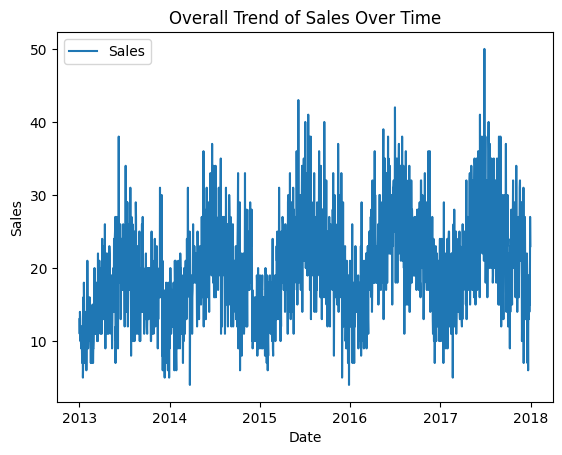

In [3]:
# Visualising the Overall Trend of Sales with respect to Date
sns.lineplot(x="date", y="sales", data=df)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Overall Trend of Sales Over Time")
plt.legend(["Sales"])
plt.show()

## Checking if the Data is Stationary

Stationarity is a fundamental assumption of ARIMA (AutoRegressive Integrated Moving Average) models because it simplifies the underlying process being modeled and facilitates accurate parameter estimation and forecasting. A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time. Here's why stationarity is needed for ARIMA:

1. Constant Statistical Properties: Stationarity implies that the statistical
properties of the time series, such as mean, variance, and autocovariance, remain constant over time. This allows us to make predictions based on past observations because the underlying data-generating process is assumed to be stable.
2. Model Stability: In a non-stationary time series, the statistical properties of the data change over time, making it challenging to develop a stable model. A non-stationary series might exhibit trends, seasonal patterns, or other forms of structural changes that can lead to biased parameter estimates and unreliable forecasts.
3. Autocorrelation Structure: ARIMA models are built on the assumption of autocorrelation, meaning that the value of the series at any given time is correlated with its previous values. Stationarity ensures that this autocorrelation structure is consistent across time, allowing ARIMA models to effectively capture and model the underlying dependencies in the data.

In summary, stationarity is essential for ARIMA models because it ensures stable statistical properties, facilitates accurate parameter estimation, and enables reliable forecasting by capturing the underlying autocorrelation structure of the time series data.

For this very reason, we try to do perform manipulations to make the data stationary. This is explaioned in the section below.

Source: https://otexts.com/fpp2/stationarity.html

In [4]:
#Writing a Function to check for Stationarity by giving a condition on p-value
def check_stationarity(input_data):

    # Assume 'data' is your time series data
    result = adfuller(input_data)

    # Extracting test statistics and p-value
    adf_statistic = result[0]
    p_value = result[1]

    # Printing test statistics and p-value
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)

    # Checking for stationarity based on p-value (we can define it acccording to our choice)
    if p_value < 0.02:
        print("Reject the null hypothesis. The data is stationary.")
    else:
        print("Fail to reject the null hypothesis. The data is non-stationary.")

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a unit root is present in a time series dataset. A unit root indicates that a time series is non-stationary, meaning its statistical properties (such as mean and variance) change over time. The ADF test helps assess whether differencing is necessary to make a time series stationary.

The ADF test provides several statistics, including the ADF statistic and the p-value. Here's what they tell you about stationarity:

1. ADF Statistic: The ADF statistic is a negative number. The more negative it is, the stronger the evidence against the presence of a unit root (i.e., in favor of stationarity). A more negative ADF statistic indicates a greater likelihood that the series is stationary.
2. P-value: The p-value associated with the ADF statistic indicates the probability of observing the ADF statistic if the null hypothesis of a unit root is true (i.e., if the series is non-stationary). A smaller p-value suggests stronger evidence against the presence of a unit root and in favor of stationarity. Conventionally, if the p-value is less than a chosen significance level (e.g., 0.05), the null hypothesis of a unit root is rejected, and the series is considered stationary.

In summary:

A smaller ADF statistic and a smaller p-value indicate stronger evidence against the presence of a unit root and in favor of stationarity.
If the ADF statistic is more negative and/or the p-value is smaller than the chosen significance level (e.g., 0.05), you can reject the null hypothesis of a unit root and conclude that the series is likely stationary.
Conversely, if the p-value is larger than the chosen significance level, you fail to reject the null hypothesis, indicating that the series may be non-stationary.

In [5]:
#checking stationarity of our time series
check_stationarity(df['sales'])

ADF Statistic: -3.1576705563328042
p-value: 0.02256938062657153
Fail to reject the null hypothesis. The data is non-stationary.


The next step is to plot Autocorrelation and Partial Autocorrelation plots to verify how non-stationary a series is. This is a standard practise.
1. Autocorrelation Plot (ACF): An autocorrelation plot, often referred to as an ACF plot, shows the correlation between a series and its lagged values. The x-axis represents the lag, i.e., the number of time units by which the series is shifted and the y-axis represents the correlation coefficient between the series and its lagged values at different lags. Significant autocorrelation at certain lags indicates a repeating pattern in the data that could be captured by autoregressive terms in an ARIMA model.
2. Partial Autocorrelation Plot (PACF): A partial autocorrelation plot, or PACF plot, shows the correlation between a series and its lagged values after removing the effect of intermediate lagged values. The x-axis represents the lag, similar to the ACF plot. The y-axis represents the partial correlation coefficient between the series and its lagged values at different lags, controlling for intermediate lags. Significant partial autocorrelation at certain lags indicates direct relationships between observations at those lags, which can help determine the order of autoregressive terms in an ARIMA model.

In the ACF plot, significant autocorrelation at lag k suggests a potential autoregressive term of order k. In the PACF plot, significant partial autocorrelation at lag k suggests a potential autoregressive term of order k. By analyzing both plots together, analysts can determine suitable values for p and q, which are crucial for building an effective ARIMA model.

We have defined statioanrity to be the case where the p-value is less than 0.02. the p-value associated with our data is 0.022 which is just above the critical value. So in our case we can say that it is borderline stationary (almost stationary). But we can try to make it stationary.

We will make us eof inbuilt functions to do this.

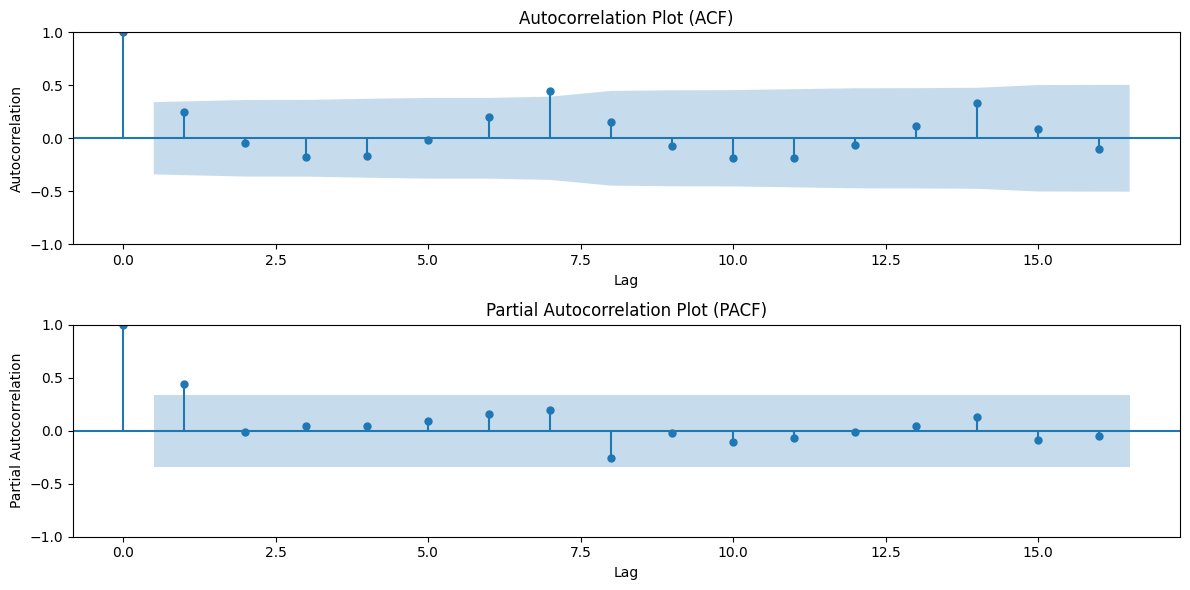

In [6]:
# Calculating autocorrelation and partial autocorrelation
df_acf = acf(df['sales'])           # Auto correlation plot
df_pacf = pacf(df['sales'])         # Partial auto correlation plot

# Creating subplots for ACF and PACF plots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plotting ACF
plot_acf(df_acf, ax=ax1)
ax1.set_title('Autocorrelation Plot (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plotting PACF
plot_pacf(df_pacf, ax=ax2)
ax2.set_title('Partial Autocorrelation Plot (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

From the above plots, we observe that for a lag greater than 1, the series is statioanr. Hence to convert our non-stationary series to a stationary series, we do a simple difference of one step. After this we observe that the series becomes stationary.

In [7]:
df_copy = df.copy()
df_copy['sales'] = df_copy['sales'] - df_copy['sales'].shift(-1)    #simple differencing, d = 1
df_copy.dropna(inplace=True)                                        #dropping NaN values to process data
df_copy

date  sales
0    2013-01-01    2.0
1    2013-01-02   -3.0
2    2013-01-03    1.0
3    2013-01-04    3.0
4    2013-01-05   -2.0
...         ...    ...
1820 2017-12-26    2.0
1821 2017-12-27   -5.0
1822 2017-12-28    4.0
1823 2017-12-29  -12.0
1824 2017-12-30    4.0

[1825 rows x 2 columns]

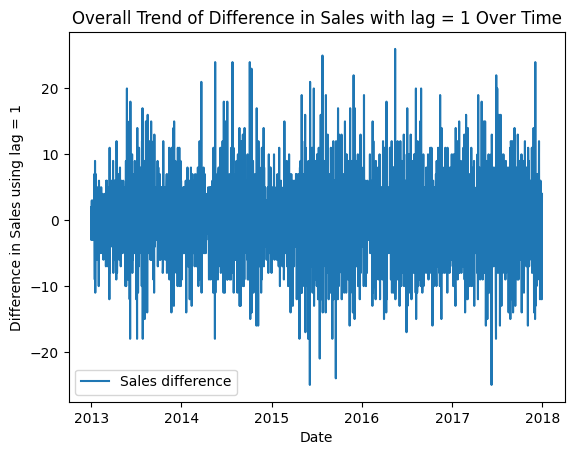

In [8]:
#visualising our new differenced data
sns.lineplot(x="date", y="sales", data=df_copy)
plt.xlabel("Date")
plt.ylabel("Difference in Sales using lag = 1")
plt.title("Overall Trend of Difference in Sales with lag = 1 Over Time")
plt.legend(["Sales difference"])
plt.show()

In [9]:
#checking stationarity of the differenced data
check_stationarity(df_copy['sales'])

ADF Statistic: -12.676793886047415
p-value: 1.2109276320440208e-23
Reject the null hypothesis. The data is stationary.


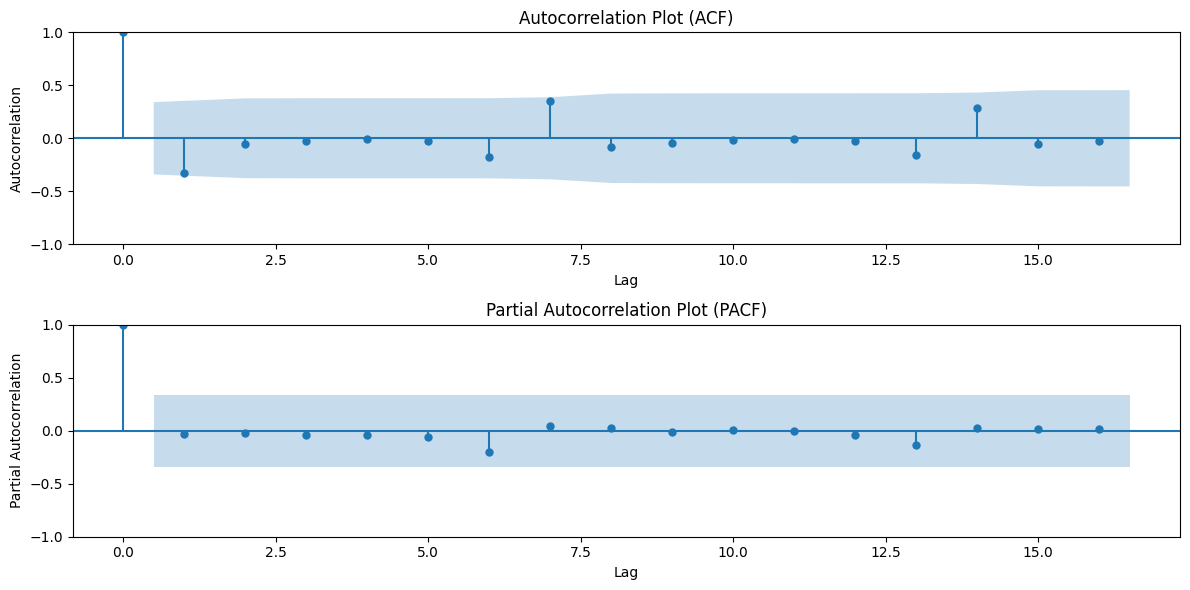

In [10]:
# Calculating autocorrelation and partial autocorrelation
df_acf2 = acf(df_copy['sales'])           # Defining Auto correlation plot
df_pacf2 = pacf(df_copy['sales'])         # Defining Partial auto correlation plot

# Creating subplots for ACF and PACF plots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plotting ACF
plot_acf(df_acf2, ax=ax1)
ax1.set_title('Autocorrelation Plot (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plotting PACF
plot_pacf(df_pacf2, ax=ax2)
ax2.set_title('Partial Autocorrelation Plot (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

From the above calculated metrics and plots, we see that our data is now stationary. As simple differencing makes our data stationary, we will use d = 1 as a parameter for fitting our ARIMA model. Keep in mind that we were lucky that a simple differencing made the data stationary. Usually a lot of different differencing ideas have to be tried to reach statioanry as it is a very ideal assumotions and there is no guarentee that a time series will be stationary.

## Fitting the ARIMA model

While training a Machine Learning model, we split our 'Supervised' Dataset into a Training Dataset and a Testing Dataset. We use the training dataset to 'train' our model and the testing dataset to verify how accurate our trained model is at predicting on unknown data (The training data is unknown to the model as we have not used it to train the paramaters).

  1. X_train: This will be the training set of features (size = 80% of training set).
  2. X_test: This will be the testing set of features (size = 20% of testing set).
  3. y_train: This will be the corresponding training set of target values (size = 80% of training set).
  4. y_test: This will be the corresponding testing set of target values (size = 20% of testing set).

By default, 80% of the data will be used for training (X_train and y_train), and 20% will be used for testing (X_test and y_test).. It is a standard practise to use an 80-20 split. The motivation behind this is loosely the Pareto principle.The Pareto principle is not a mathematically guaranteed property, but many observed phenomena follow the Pareto principle. As it is seen ubiquitous in nature, we try to emulate the same conjecture with our model. After all, we are trying to emulate 'intelligence'.

In [39]:
#dividing the data into training and testing datasets
df_train_arima = df[:int(0.8*(len(df)))]
df_test_arima = df[int(0.8*(len(df))):]

In [40]:
#defining the ARIMA model with relevant p,d,q parameters
model = statsmodels.tsa.arima.model.ARIMA(df['sales'], order=(1,1,1))
fit_model = model.fit()

In [41]:
#forecasting values on the testing dataset
df_test_arima['forecast'] = fit_model.predict(start = df_test_arima.index[0], end = df_test_arima.index[-1])
df_test_arima

<ipython-input-41-39f836dc4e46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_arima['forecast'] = fit_model.predict(start = df_test_arima.index[0], end = df_test_arima.index[-1])


date  sales   forecast
1460 2016-12-31     14  17.939589
1461 2017-01-01     19  16.902685
1462 2017-01-02     15  17.431197
1463 2017-01-03     10  16.948956
1464 2017-01-04     16  16.037696
...         ...    ...        ...
1821 2017-12-27     14  16.433387
1822 2017-12-28     19  16.096195
1823 2017-12-29     15  16.688331
1824 2017-12-30     27  16.264695
1825 2017-12-31     23  17.982937

[366 rows x 3 columns]

## Visualising Results

<ipython-input-42-0f7064159a6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_arima['error'] = df_test_arima['sales'] - df_test_arima['forecast']


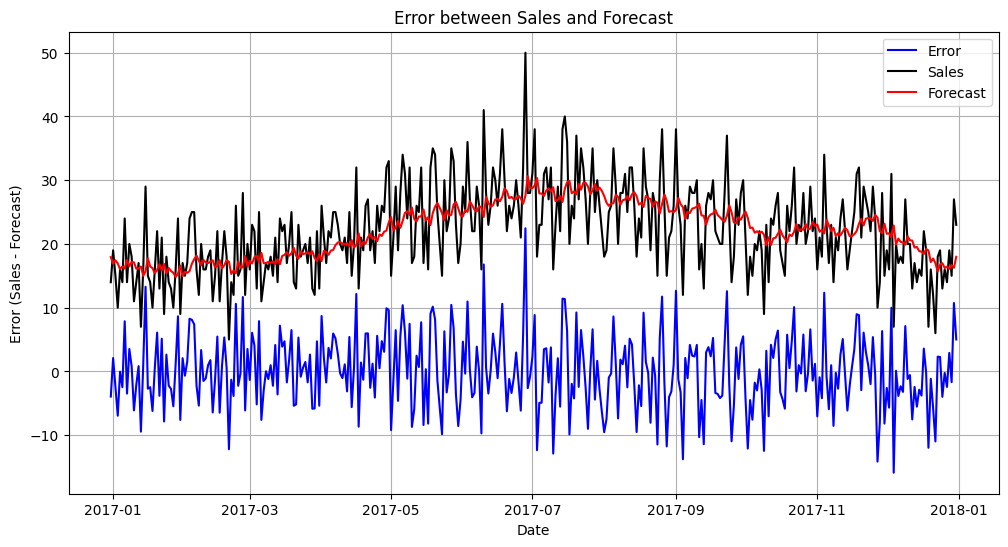

In [42]:
# Step 1: Calculate the error
df_test_arima['error'] = df_test_arima['sales'] - df_test_arima['forecast']

# Step 2: Visualize the error
plt.figure(figsize=(12, 6))
plt.plot(df_test_arima['date'], df_test_arima['error'], color='blue', label="Error")
plt.plot(df_test_arima['date'], df_test_arima['sales'], color='black', label="Sales")
plt.plot(df_test_arima['date'], df_test_arima['forecast'], color='red', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Error (Sales - Forecast)')
plt.title('Error between Sales and Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Step 3: Calculate the mean error (ME) and root mean squared error (MSE)
ME = np.mean(df_test_arima['error'])
RMSE = np.sqrt(np.mean(df_test_arima['error'] ** 2))
RMSE_per_of_avgsales = (RMSE / np.mean(df_test_arima['sales']) )*100

print(f"Mean Error (ME): {ME}")
print(f"Root Mean Squared Error (RMSE): {RMSE}")
print(f"RMSE as a percentage of average sales: {RMSE_per_of_avgsales}%")

Mean Error (ME): 0.007664849330170219
Root Mean Squared Error (RMSE): 5.84990337855445
RMSE as a percentage of average sales: 26.397048903352594%


We see that the mean error is very small but the RMSE as a percentage of sales is high. This indicates that the model captures the trend but does not capture the variance.

Let us plot a graph to visualise the actual price forecast and the predicted price forecast.

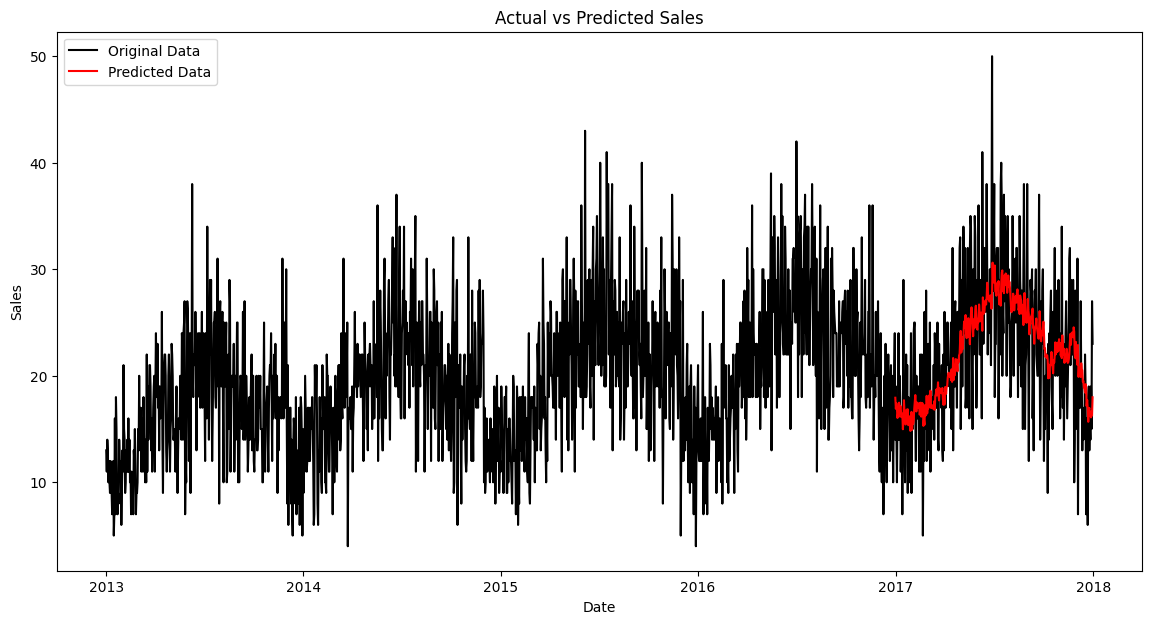

In [44]:
# Plotting actual vs predicted results
plt.figure(figsize=(14,7))
plt.plot(df['date'], df['sales'], color='black', label="Original Data")
plt.plot(df_test_arima['date'], df_test_arima['forecast'], color='red', label="Predicted Data")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

## Conclusion

From our exercise, we can say

1. We see that our ARIMA model has caputured the trend of the underlying data pretty well. It closely follows the mean of the trend.
2. It has not been able to capture the intricacies of the spread apart from a basic trend. This may be due to the inherent underfitting nature of ARIMA.
3. One reason I think that the ARIMA is not a great fit for this data is that the data had some seasonal patterns and more complex relationships apart from the basic regression, which ARIMA is not good at capturing.

ARIMA is not usually very good at capturing long term trends as well. The variance keeps on increasing the further we go into the future and the trend line doesnt perform as well. As we have a very strcutured and possibly manufactured dataset, it is very diffciult to show this as our model will fit the data well into the future.

In general, we can say that ARIMA is alright for a simple series but does not perform well for complex real-world scenarios. Thre are a few pros and cons of the ARIMA model.

**Pros:**

1. Flexibility: ARIMA models can capture a wide range of temporal patterns, including trend, seasonality, and autocorrelation, making them suitable for various types of time series data.
Interpretability: The parameters of ARIMA models (e.g., autoregressive order, moving average order, differencing order) have clear interpretations, making it easier to understand the underlying dynamics of the data.
2. Well-Studied: ARIMA models have been extensively studied and are well-established in the literature. There are robust methodologies for parameter estimation, model diagnostics, and forecasting evaluation.
No Assumptions About Data Distribution: ARIMA models do not assume a specific distribution for the underlying data, making them suitable for non-normal or unknown distributions.
3. Easily Implementable: ARIMA models are relatively easy to implement, especially with the availability of software packages and libraries (e.g., statsmodels in Python).

**Cons:**

1. Stationarity Requirement: ARIMA models assume that the time series data is stationary or can be made stationary through differencing. In practice, achieving stationarity may require complex transformations or detrending techniques.
2. Limited Handling of Seasonality: Traditional ARIMA models do not handle seasonal patterns explicitly. Seasonal ARIMA (SARIMA) models address this limitation by incorporating seasonal components, but they may require more parameters and data for estimation.
3. Sensitivity to Model Selection: Selecting the appropriate orders (p, d, q) for the autoregressive, differencing, and moving average components of the ARIMA model can be challenging and often requires diagnostic checks and model selection criteria.
4. Limited Forecast Horizon: ARIMA models are generally suitable for short to medium-term forecasting. For longer-term forecasts or when dealing with highly volatile or complex data, other forecasting methods like machine learning algorithms may be more appropriate.
5. Assumption of Linear Relationships: ARIMA models assume linear relationships between past observations and future values, which may not always hold true in practice, especially for nonlinear or dynamic systems.

In summary, while ARIMA models offer many advantages, they also have limitations, particularly regarding the stationarity assumption, handling of seasonality, sensitivity to model selection, and forecasting horizon. Understanding these pros and cons is essential for effectively applying ARIMA models to real-world time series data.

# **SARIMAX Model**

## Introduction to the topic

In this section, we are trying to predict future sales trend using the SARIMAX model. A SARIMAX (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors) model is a generalization of the ARIMA model that considers both seasonality and exogenous variables. SARIMAX models are among the most widely used statistical models for forecasting, with excellent forecasting performance. Adding to the definition of ARIMA,

*  Seasonal(S) - It stands for seasonality. In case if you identify that the data patterns is repeating every month /year then yes it is seasonality.
*  Exogenous Variables(X) - It stands for other exogeneous variables which causes the variable to change. It is used while we are doing multi variate time series analysis.

Adding more components to the ARIMA model gives us the SARIMAX model. The parameters can be defined as:

* P is the order (number of time lags) of the seasonal part of the model
* D is the degree of differencing (the number of times the data have had past values subtracted) of the seasonal part of the model.
* Q is the order of the moving-average of the seasonal part of the model.
* s refers to the number of periods in each season.

Source: https://joaquinamatrodrigo.github.io/skforecast/0.7.0/user_guides/forecasting-sarimax-arima.html

## Describing the Dataset

The dataset which I have used is a Sales dataset for number of items sold in a particular store over 5+ years. I had the data for 10 different stores and 10+ items in each store but for the purpsoes of demonstration, we have taken only 1 store and 1 item. I do not know what the store is or what the items are as the data is picked up from Kaggle and the description does not mention anything. As the goal is to do a time series forecasting using ARIMA, the data seemed very structured and great to work with hence the choice.

After filtering the data accordingly, the data we have gives us information about the sales of 1 item sold in 1 store from 1 January 2013 to 31 December 2017.

Source of Dataset: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

## Importing all the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

## Importing Data, Processing it and Visualizing it

In [5]:
df = pd.read_csv('/content/train.csv')            #Reading Data
df = df[df['store']==1]                           #Filtering Store number 1
df = df[df['item']==1]                            #Filtering Item number 1
df = df.drop(['item','store'], axis=1)            #Dropping all other columns
df['date'] = pd.to_datetime(df['date'])           #Converting to proper format
df

date  sales
0    2013-01-01     13
1    2013-01-02     11
2    2013-01-03     14
3    2013-01-04     13
4    2013-01-05     10
...         ...    ...
1821 2017-12-27     14
1822 2017-12-28     19
1823 2017-12-29     15
1824 2017-12-30     27
1825 2017-12-31     23

[1826 rows x 2 columns]

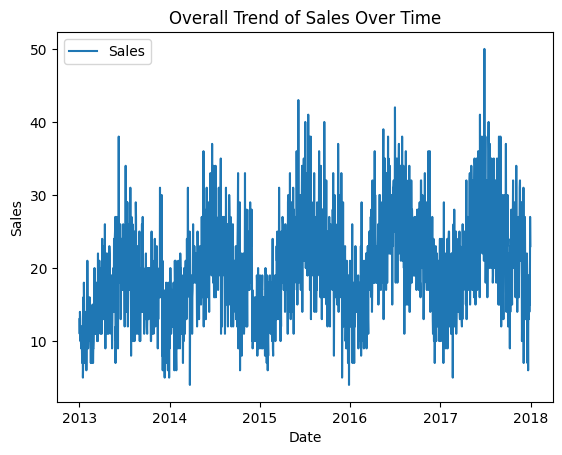

In [6]:
# Visualising the Overall Trend of Sales with respect to Date
sns.lineplot(x="date", y="sales", data=df)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Overall Trend of Sales Over Time")
plt.legend(["Sales"])
plt.show()

## Checking if the Data is Stationary

Stationarity is a fundamental assumption of SARIMAX models because it simplifies the underlying process being modeled and facilitates accurate parameter estimation and forecasting. A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time. Here's why stationarity is needed for SARIMAX:

1. Constant Statistical Properties: Stationarity implies that the statistical
properties of the time series, such as mean, variance, and autocovariance, remain constant over time. This allows us to make predictions based on past observations because the underlying data-generating process is assumed to be stable.
2. Model Stability: In a non-stationary time series, the statistical properties of the data change over time, making it challenging to develop a stable model. A non-stationary series might exhibit trends, seasonal patterns, or other forms of structural changes that can lead to biased parameter estimates and unreliable forecasts.
3. Autocorrelation Structure: SARIMAX models are built on the assumption of autocorrelation, meaning that the value of the series at any given time is correlated with its previous values. Stationarity ensures that this autocorrelation structure is consistent across time, allowing SARIMAX models to effectively capture and model the underlying dependencies in the data.

In summary, stationarity is essential for SARIMAX models because it ensures stable statistical properties, facilitates accurate parameter estimation, and enables reliable forecasting by capturing the underlying autocorrelation structure of the time series data.

For this very reason, we try to do perform manipulations to make the data stationary. This is explaioned in the section below.

Source: https://otexts.com/fpp2/stationarity.html

In [8]:
#Writing a Function to check for Stationarity by giving a condition on p-value
def check_stationarity(input_data):

    # Assume 'data' is your time series data
    result = adfuller(input_data)

    # Extracting test statistics and p-value
    adf_statistic = result[0]
    p_value = result[1]

    # Printing test statistics and p-value
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)

    # Checking for stationarity based on p-value (we can define it acccording to our choice)
    if p_value < 0.02:
        print("Reject the null hypothesis. The data is stationary.")
    else:
        print("Fail to reject the null hypothesis. The data is non-stationary.")

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a unit root is present in a time series dataset. A unit root indicates that a time series is non-stationary, meaning its statistical properties (such as mean and variance) change over time. The ADF test helps assess whether differencing is necessary to make a time series stationary.

The ADF test provides several statistics, including the ADF statistic and the p-value. Here's what they tell you about stationarity:

1. ADF Statistic: The ADF statistic is a negative number. The more negative it is, the stronger the evidence against the presence of a unit root (i.e., in favor of stationarity). A more negative ADF statistic indicates a greater likelihood that the series is stationary.
2. P-value: The p-value associated with the ADF statistic indicates the probability of observing the ADF statistic if the null hypothesis of a unit root is true (i.e., if the series is non-stationary). A smaller p-value suggests stronger evidence against the presence of a unit root and in favor of stationarity. Conventionally, if the p-value is less than a chosen significance level (e.g., 0.05), the null hypothesis of a unit root is rejected, and the series is considered stationary.

In summary:

A smaller ADF statistic and a smaller p-value indicate stronger evidence against the presence of a unit root and in favor of stationarity.
If the ADF statistic is more negative and/or the p-value is smaller than the chosen significance level (e.g., 0.05), you can reject the null hypothesis of a unit root and conclude that the series is likely stationary.
Conversely, if the p-value is larger than the chosen significance level, you fail to reject the null hypothesis, indicating that the series may be non-stationary.

In [9]:
#checking stationarity of our time series
check_stationarity(df['sales'])

ADF Statistic: -3.1576705563328042
p-value: 0.02256938062657153
Fail to reject the null hypothesis. The data is non-stationary.


The next step is to plot Autocorrelation and Partial Autocorrelation plots to verify how non-stationary a series is. This is a standard practise.
1. Autocorrelation Plot (ACF): An autocorrelation plot, often referred to as an ACF plot, shows the correlation between a series and its lagged values. The x-axis represents the lag, i.e., the number of time units by which the series is shifted and the y-axis represents the correlation coefficient between the series and its lagged values at different lags. Significant autocorrelation at certain lags indicates a repeating pattern in the data that could be captured by autoregressive terms in an ARIMA model.
2. Partial Autocorrelation Plot (PACF): A partial autocorrelation plot, or PACF plot, shows the correlation between a series and its lagged values after removing the effect of intermediate lagged values. The x-axis represents the lag, similar to the ACF plot. The y-axis represents the partial correlation coefficient between the series and its lagged values at different lags, controlling for intermediate lags. Significant partial autocorrelation at certain lags indicates direct relationships between observations at those lags, which can help determine the order of autoregressive terms in an ARIMA model.

In the ACF plot, significant autocorrelation at lag k suggests a potential autoregressive term of order k. In the PACF plot, significant partial autocorrelation at lag k suggests a potential autoregressive term of order k. By analyzing both plots together, analysts can determine suitable values for p and q, which are crucial for building an effective SARIMAX model.

We have defined statioanrity to be the case where the p-value is less than 0.02. the p-value associated with our data is 0.022 which is just above the critical value. So in our case we can say that it is borderline stationary (almost stationary). But we can try to make it stationary.

We will make use of inbuilt functions to do this.

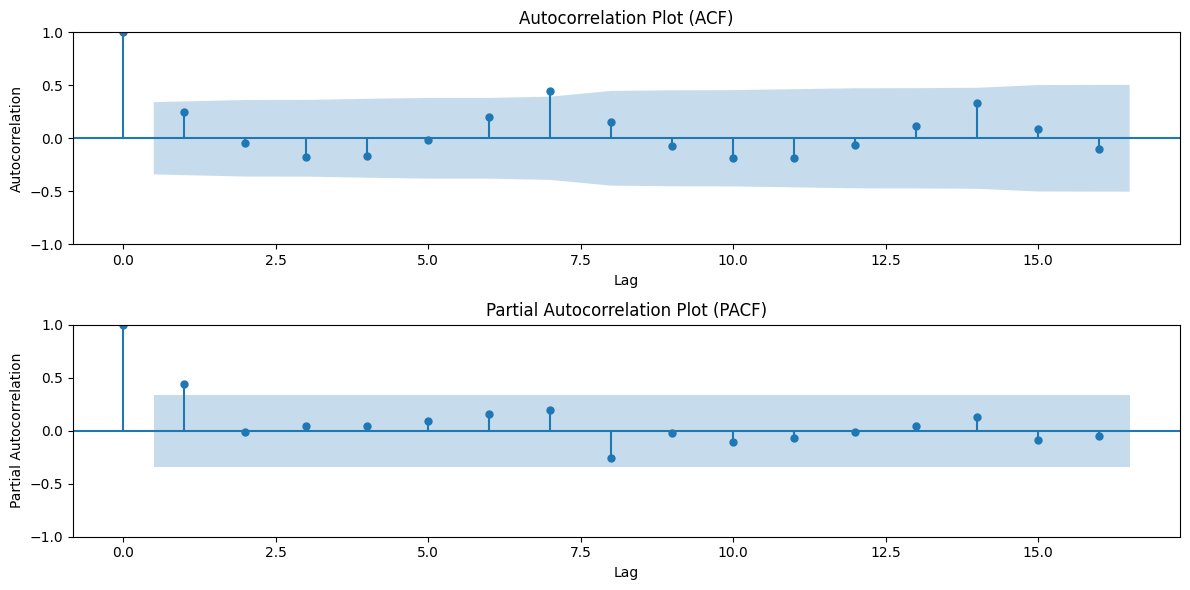

In [10]:
# Calculating autocorrelation and partial autocorrelation
df_acf = acf(df['sales'])           # Auto correlation plot
df_pacf = pacf(df['sales'])         # Partial auto correlation plot

# Creating subplots for ACF and PACF plots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plotting ACF
plot_acf(df_acf, ax=ax1)
ax1.set_title('Autocorrelation Plot (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plotting PACF
plot_pacf(df_pacf, ax=ax2)
ax2.set_title('Partial Autocorrelation Plot (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

From the above plots, we observe that for a lag greater than 1, the series is stationary. Hence to convert our non-stationary series to a stationary series, we do a simple difference of one step. After this we observe that the series becomes stationary.

In [11]:
df_copy = df.copy()
df_copy['sales'] = df_copy['sales'] - df_copy['sales'].shift(-1)    #simple differencing, d = 1
df_copy.dropna(inplace=True)                                        #dropping NaN values to process data
df_copy

date  sales
0    2013-01-01    2.0
1    2013-01-02   -3.0
2    2013-01-03    1.0
3    2013-01-04    3.0
4    2013-01-05   -2.0
...         ...    ...
1820 2017-12-26    2.0
1821 2017-12-27   -5.0
1822 2017-12-28    4.0
1823 2017-12-29  -12.0
1824 2017-12-30    4.0

[1825 rows x 2 columns]

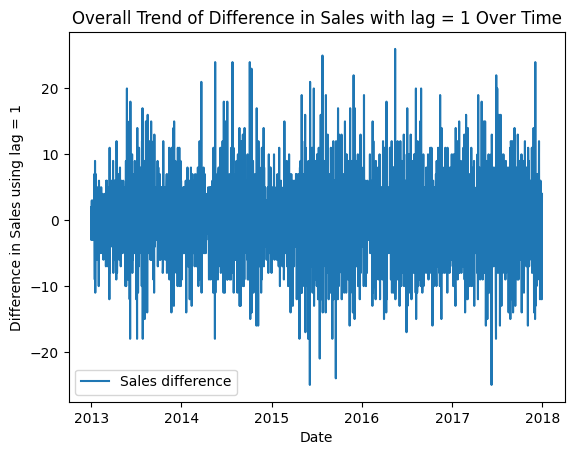

In [12]:
# Visualising our new differenced data
sns.lineplot(x="date", y="sales", data=df_copy)
plt.xlabel("Date")
plt.ylabel("Difference in Sales using lag = 1")
plt.title("Overall Trend of Difference in Sales with lag = 1 Over Time")
plt.legend(["Sales difference"])
plt.show()

In [13]:
#checking stationarity of the differenced data
check_stationarity(df_copy['sales'])

ADF Statistic: -12.676793886047415
p-value: 1.2109276320440208e-23
Reject the null hypothesis. The data is stationary.


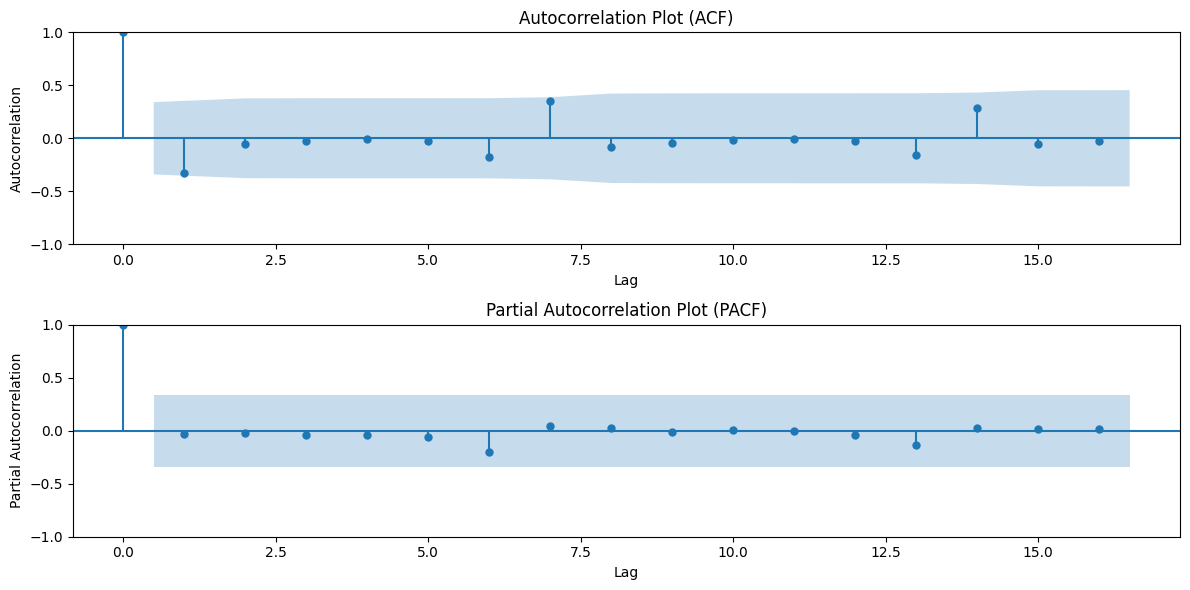

In [14]:
# Calculating autocorrelation and partial autocorrelation
df_acf2 = acf(df_copy['sales'])           # Defining Auto correlation plot
df_pacf2 = pacf(df_copy['sales'])         # Defining Partial auto correlation plot

# Creating subplots for ACF and PACF plots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plotting ACF
plot_acf(df_acf2, ax=ax1)
ax1.set_title('Autocorrelation Plot (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plotting PACF
plot_pacf(df_pacf2, ax=ax2)
ax2.set_title('Partial Autocorrelation Plot (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

From the above calculated metrics and plots, we see that our data is now stationary. As simple differencing makes our data stationary, we will use d = 1 as a parameter for fitting our SARIMAX model. Keep in mind that we were lucky that a simple differencing made the data stationary. Usually a lot of different differencing ideas have to be tried to reach statioanry as it is a very ideal assumotions and there is no guarentee that a time series will be stationary.

**Now for the Seasonal Component**

Let us also repeat this same process for seasonal changes --> checking for stationarity over a difference of 365 days instead of 1 day. All the other process stays the same and hence will not be detailed again.

In [16]:
#creating yt = yt - y(t-365)
df_copy2 = df.copy()
df_copy2['sales'] = df_copy2['sales'] - df_copy2['sales'].shift(-365)    #simple differencing, d = 1
df_copy2.dropna(inplace=True)                                            #dropping NaN values to process data
df_copy2

date  sales
0    2013-01-01    4.0
1    2013-01-02   -3.0
2    2013-01-03    3.0
3    2013-01-04   -7.0
4    2013-01-05   -7.0
...         ...    ...
1456 2016-12-27   -4.0
1457 2016-12-28   -3.0
1458 2016-12-29    6.0
1459 2016-12-30   -3.0
1460 2016-12-31   -9.0

[1461 rows x 2 columns]

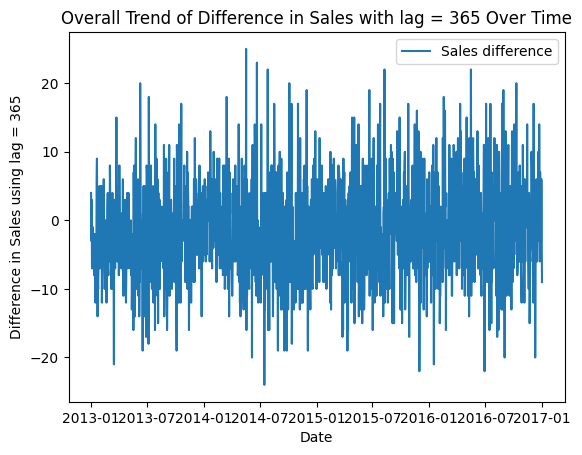

In [17]:
# Visualising our new differenced data
sns.lineplot(x="date", y="sales",legend = 'full' , data=df_copy2)
plt.xlabel("Date")
plt.ylabel("Difference in Sales using lag = 365")
plt.title("Overall Trend of Difference in Sales with lag = 365 Over Time")
plt.legend(["Sales difference"])
plt.show()

In [18]:
#checking stationarity
check_stationarity(df_copy2['sales'])

ADF Statistic: -6.748944634261218
p-value: 2.9850544107741883e-09
Reject the null hypothesis. The data is stationary.


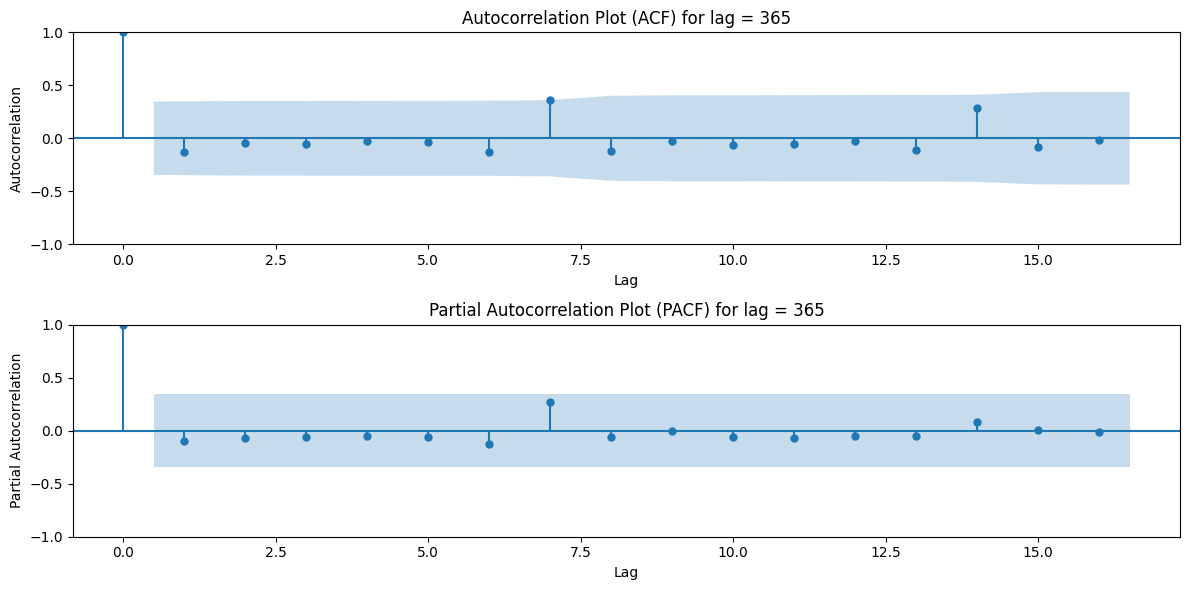

In [20]:
# Calculating autocorrelation and partial autocorrelation
df_acf3 = acf(df_copy2['sales'])                        #defining auto correlation plot
df_pacf3 = pacf(df_copy2['sales'])                      #defining partial auto correlation plot

# Creating subplots for ACF and PACF plots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plotting ACF
plot_acf(df_acf3, ax=ax1)
ax1.set_title('Autocorrelation Plot (ACF) for lag = 365')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plotting PACF
plot_pacf(df_pacf3, ax=ax2)
ax2.set_title('Partial Autocorrelation Plot (PACF) for lag = 365')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

Therefore we can see that our data is stationary with respect to seasonality as well.

## Fitting the SARIMAX model

The general idea: While training a Machine Learning model, we split our 'Supervised' Dataset into a Training Dataset and a Testing Dataset. We use the training dataset to 'train' our model and the testing dataset to verify how accurate our trained model is at predicting on unknown data (The training data is unknown to the model as we have not used it to train the paramaters).

  1. X_train: This will be the training set of features (size = 80% of training set).
  2. X_test: This will be the testing set of features (size = 20% of testing set).
  3. y_train: This will be the corresponding training set of target values (size = 80% of training set).
  4. y_test: This will be the corresponding testing set of target values (size = 20% of testing set).

By default, 80% of the data will be used for training (X_train and y_train), and 20% will be used for testing (X_test and y_test).. It is a standard practise to use an 80-20 split. The motivation behind this is loosely the Pareto principle.The Pareto principle is not a mathematically guaranteed property, but many observed phenomena follow the Pareto principle. As it is seen ubiquitous in nature, we try to emulate the same conjecture with our model. After all, we are trying to emulate 'intelligence'.

In our case: As we do not have the data for too many 'years', we have limited 'seasonal data' as well. Hence we compromise on the 80-20 and make it a 60-40 split so as to be able to predict for 2 seasons atleast. In a case with a lot of data, we would not do this.

In [32]:
#dividing data into training and testing datasets
df_train_sarimax = df[:int(0.8*(len(df)))]
df_test_sarimax = df[int(0.8*(len(df))):]

In [33]:
#defining a model with relevant p,d,q parameters
model = sm.tsa.SARIMAX(df['sales'], order=(1,1,1),seasonal_order=(2,1,2,12))
fit_model = model.fit()

In [34]:
#Forecasting based on our SARIMAX model
df_test_sarimax['forecast'] = fit_model.predict(start = df_test_sarimax.index[0], end = df_test_sarimax.index[-1])
df_test_sarimax

<ipython-input-34-594b7339e37c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sarimax['forecast'] = fit_model.predict(start = df_test_sarimax.index[0], end = df_test_sarimax.index[-1])


date  sales   forecast
1460 2016-12-31     14  17.437742
1461 2017-01-01     19  17.166383
1462 2017-01-02     15  17.295712
1463 2017-01-03     10  16.966413
1464 2017-01-04     16  16.451706
...         ...    ...        ...
1821 2017-12-27     14  15.851941
1822 2017-12-28     19  16.751014
1823 2017-12-29     15  16.161676
1824 2017-12-30     27  15.773074
1825 2017-12-31     23  18.096018

[366 rows x 3 columns]

## Visualising Results

<ipython-input-36-790f991fe8a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sarimax['error'] = df_test_sarimax['sales'] - df_test_sarimax['forecast']


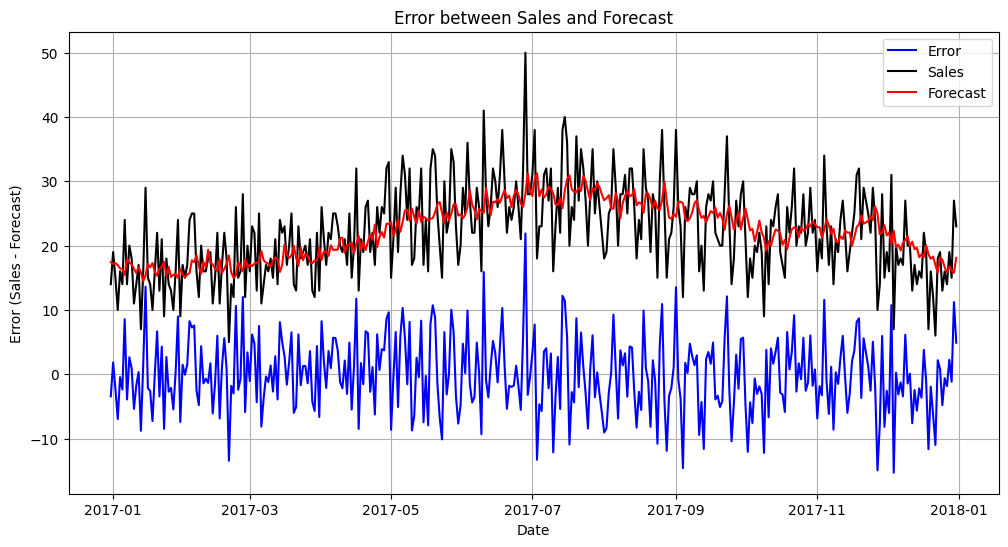

In [36]:
# Step 1: Calculate the error
df_test_sarimax['error'] = df_test_sarimax['sales'] - df_test_sarimax['forecast']

# Step 2: Visualize the error
plt.figure(figsize=(12, 6))
plt.plot(df_test_sarimax['date'], df_test_sarimax['error'], color='blue', label="Error")
plt.plot(df_test_sarimax['date'], df_test_sarimax['sales'], color='black', label="Sales")
plt.plot(df_test_sarimax['date'], df_test_sarimax['forecast'], color='red', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Error (Sales - Forecast)')
plt.title('Error between Sales and Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Step 3: Calculate the mean error (ME) and root mean squared error (MSE)
ME = np.mean(df_test_sarimax['error'])
RMSE = np.sqrt(np.mean(df_test_sarimax['error'] ** 2))
RMSE_per_of_avgsales = (RMSE / np.mean(df_test_sarimax['sales']) )*100

print(f"Mean Error (ME): {ME}")
print(f"Root Mean Squared Error (RMSE): {RMSE}")
print(f"RMSE as a percentage of average sales: {RMSE_per_of_avgsales}%")

Mean Error (ME): -0.07040356148786871
Root Mean Squared Error (RMSE): 5.8305041224348075
RMSE as a percentage of average sales: 26.309511882765868%


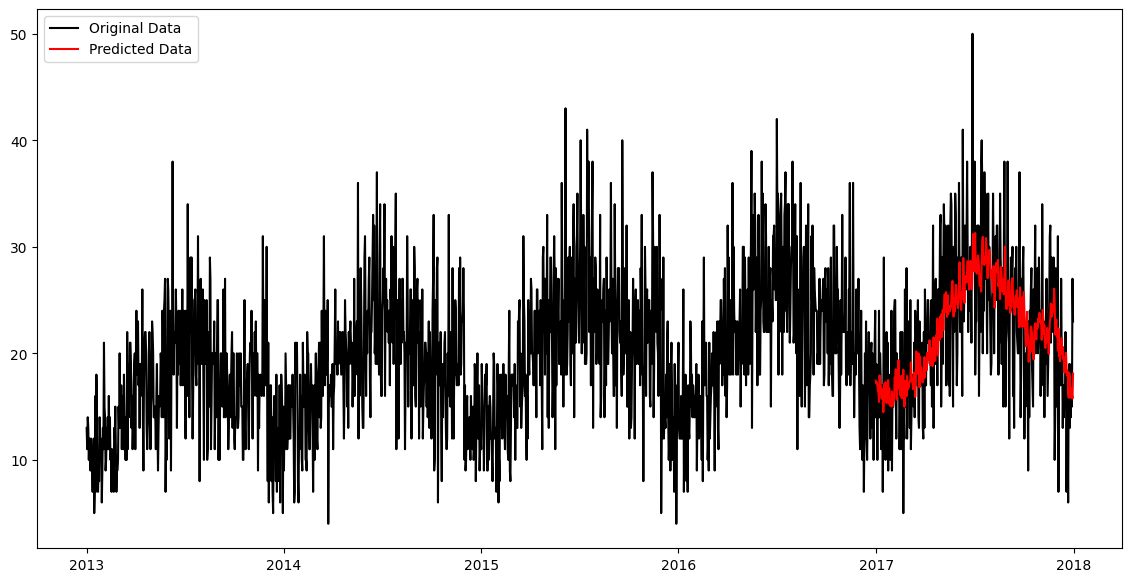

In [38]:
#Plotting original data and forecasted data
plt.figure(figsize=(14,7))
plt.plot(df['date'],df['sales'],color='black',label="Original Data")
plt.plot(df_test_sarimax['date'],df_test_sarimax['forecast'],color='red',label="Predicted Data")
plt.legend()
plt.show()

## Comparing ARIMA and SARIMAX

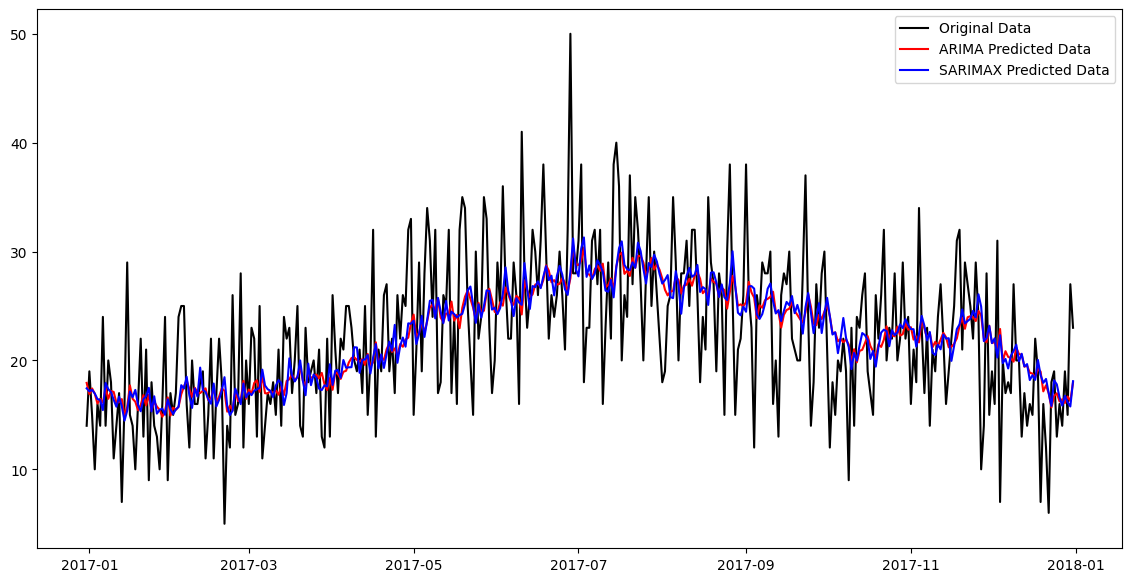

In [47]:
# Plotting original data and data forecasted by ARIMA and SARIMAX
plt.figure(figsize=(14,7))
plt.plot(df_test_sarimax['date'],df_test_sarimax['sales'],color='black',label="Original Data")
plt.plot(df_test_arima['date'],df_test_arima['forecast'],color='red',label="ARIMA Predicted Data")
plt.plot(df_test_sarimax['date'],df_test_sarimax['forecast'],color='blue',label="SARIMAX Predicted Data")
plt.legend()
plt.show()

There is not too much noticeable difference in the individual forecasts except that the SARIMAX performs very slightly better after comparing the calculated metrics. One possible reason for this can be that the data was non-complex. ARIMA is very good at modelling data which has a trend and hence we see no noticeable difference. Had the data been more complex, the SARIMAX model would give results very different from the ARIMA model.

## Conclusion

From our exercise, we can say

1. We see that our SARIMAX model has caputured the trend of the underlying data pretty well.
2. As compared to the plain ARIMA model, the SARIMAX model has been more succcessful (atleast by a little) in capturing the spread/variance as well and hence is a more powerful tool. Unfortunately, we could not see the greater effects due to the data being very ideal.

There are a few pros and cons of the SARIMAX model.

Pros:
* Interpretable: SARIMAX models have a well-defined mathematical framework, making them easier to interpret and understand. The model parameters represent the relationships between the past observations and future predictions.

* Incorporates Seasonality: SARIMAX models can handle time series data with seasonal patterns by including seasonal components in the model. This makes them suitable for forecasting data with recurring patterns.

* Limited Training Data: SARIMAX can work well with small to moderate-sized datasets, as it primarily relies on past observations and their lags. It does not require a large amount of training data to make accurate predictions.

Cons:
* Complex Parameter Selection: SARIMAX models involve selecting appropriate orders (p, d, q) and seasonal orders (P, D, Q, S) based on the characteristics of the data. This process can be challenging and time-consuming, requiring domain expertise and iterative model fitting.

* Limited Feature Engineering: SARIMAX does not inherently handle complex feature engineering tasks like XGBoost. It primarily focuses on lagged values of the target variable and exogenous variables, if any.

Source: https://ogre51.medium.com/time-series-forecasting-a-comparative-analysis-of-sarimax-and-xgboost-algorithms-7cac99685564

# **Logistic Regression**

## Introduction to the topic

Logistic regression is defined as a supervised machine learning algorithm that accomplishes binary classification tasks by predicting the probability of an outcome, event, or observation. Logical regression analyzes the relationship between one or more independent variables and classifies data into discrete classes. It is extensively used in predictive modeling, where the model estimates the mathematical probability of whether an instance belongs to a specific category or not. Logistic regression is commonly used in binary classification problems where the outcome variable reveals either of the two categories (0 and 1). Usually,
* 0 represents a negative class
* 1 represents a positive class

Source: https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/#lg=1&slide=0

The problem that we are trying to tackle today is the one of prediction if a person will default on their credit card payment (class 0) or not (class 1) based on some input parameters.

All images have been taken from https://github.com/MatteoM95/Default-of-Credit-Card-Clients-Dataset-Analisys?tab=readme-ov-file#feature-selection

## Describing the dataset

The dataset which I have used is has been downloaded from https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients.

It is a dataset of customers' default payments in Taiwan. There is so defined timeframe of the dataset except the information provided while elaborating on the variables below. Any and all info regarding the dataset is detailed below in the link provided below.

The variables in the dataset are as follows.
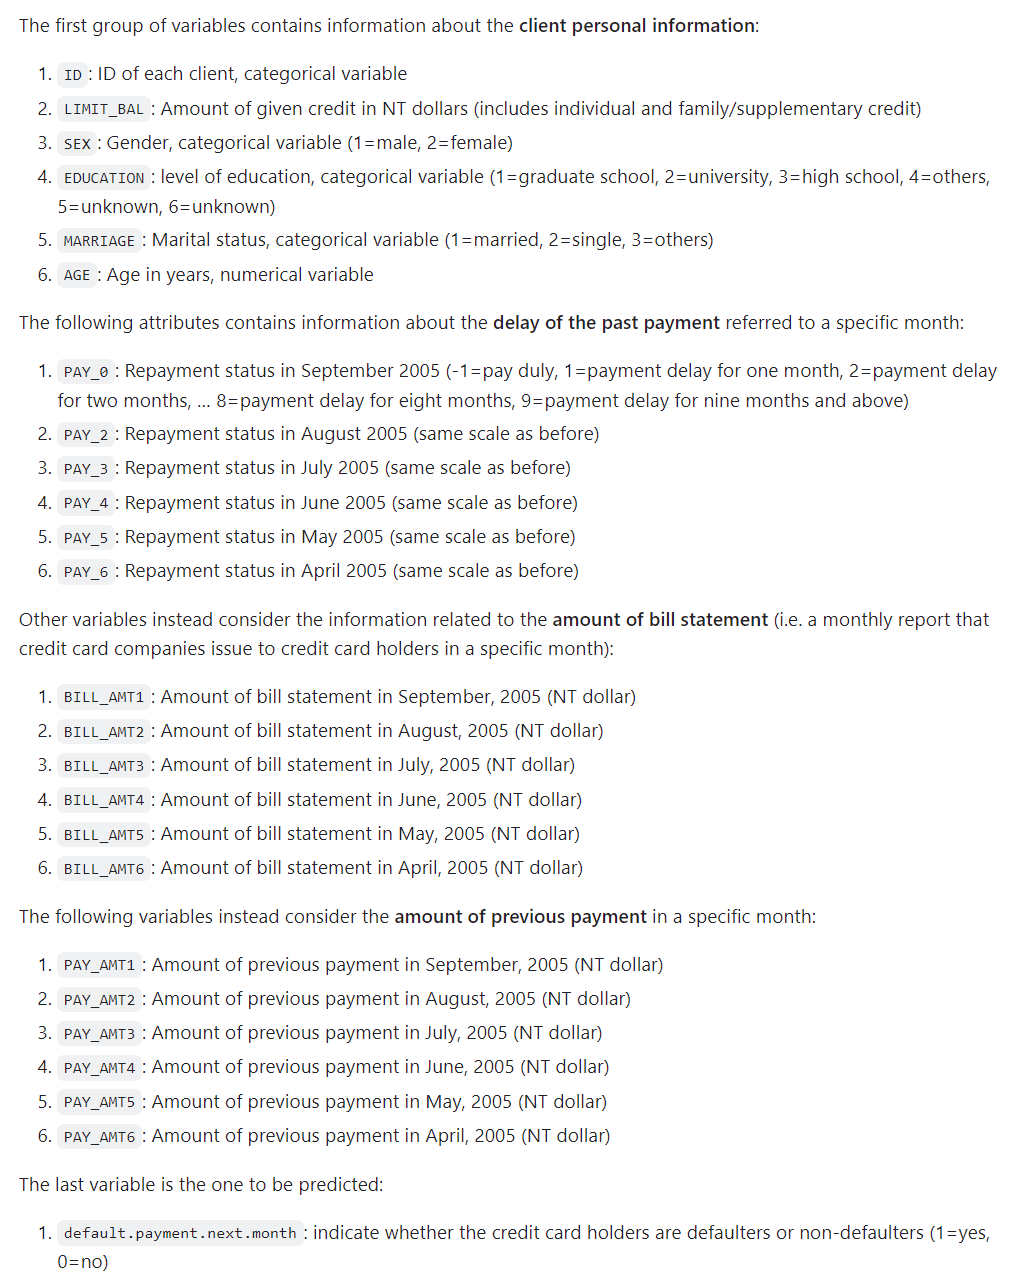![image.png]()


## Importing all necessary libraries

In [48]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

## Importing Data, Processing it and visualising it

In [49]:
df = pd.read_excel('/content/DefaultCC.xlsx')   #reading the data
df = df.drop(df[df['marriage'] == 0].index)     #cleaning the dataset
df = df.drop(df[df['education'] == 0].index)    #cleaning the dataset
df = df.drop(df[df['education'] == 5].index)    #cleaning the dataset
df = df.drop(df[df['education'] == 6].index)    #cleaning the dataset
df

id  limit_bal  sex  education  marriage  age  pay_1  pay_2  pay_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       pay_4  ...  bill_4  bill_5  bill_6  pay_1.1  pay_2.1  pay_3.1  pay_4.1  \
0         -1  ...       0       0       0        0      689        0        0   
1          0  ...    3272    3455    3261        0     1000     1000     1000   
2          0  ...   14331   14948   15549     1518     1500     1000     1000   
3          0  ...   28314   28959   29547     2000     2019     1200     1100   
4          0  ...   20940   19146   19131     2000    36681    10000     9000   
...      ...  ...     ...     ...     ...      ...      ...      ...      ...   
29995      0  ...   88004   31237   15980     8500    20000     5003     3047   
29996     -1  ...    8979    5190       0     1837     3526     8998      129   
29997     -1  ...   20878   20582   19357        0        0    22000     4200   
29998      0  ...   52774   11855   48944    85900     3409     1178     1926   
29999      0  ...   36535   32428   15313     2078     1800     1430     1000   

       pay_5.1  pay_6.1  dflt  
0            0        0     1  
1            0     2000     1  
2         1000     5000     0  
3         1069     1000     0  
4          689      679     0  
...        ...      ...   ...  
29995     5000     1000     0  
29996        0        0     0  
29997     2000     3100     1  
29998    52964     1804     1  
29999     1000     1000     1  

[29601 rows x 25 columns]

Splitting data into independent and dependent variables is a fundamental step in many types of statistical analysis and machine learning tasks, including regression analysis, classification, and forecasting. The purpose of this splitting is to prepare the data for modeling by separating the features or predictors (independent variables) from the target or response variable (dependent variable).

1. Model Building: In most statistical and machine learning models, we aim to build a relationship between the input variables (independent variables) and the output variable (dependent variable). By separating them, we can clearly define what we are trying to predict or explain.
2. Prediction: In predictive modeling tasks, the independent variables are used to make predictions about the dependent variable. Splitting the data allows us to train the model on one subset (training set) and evaluate its performance on another subset (testing set or validation set).
3. Generalization: By evaluating the model's performance on a separate dataset (testing set or validation set), we can assess its ability to generalize to new, unseen data. This is essential for determining whether the model has learned meaningful patterns or is simply memorizing the training data.
4. Feature Engineering: Splitting the data facilitates feature engineering, where we can preprocess, transform, or create new features based on the independent variables without affecting the dependent variable.

In summary, splitting data into independent and dependent variables is a crucial step in preparing data for modeling, enabling effective model building, evaluation, and generalization. It helps ensure that the model learns meaningful patterns from the data and can make accurate predictions or inferences on new, unseen data.

In our data, we have 24 independent variables(x, x1 to x24) and 1 dependent variable(y). This dependent variable is the "Dflt" column which tells us if the customer has defaulted on a loan or not. Hence, this is how we will split our dataset.:

In [50]:
# Storing the independent variable and dependent variables in separate dataframes
# Indepenedt variables will have 24 columns and dependent variable will have 1 column
df_x = df.iloc[: , :-1]
df_x = df.drop(['id'],axis=1)
df_y = df['dflt']
df_x

limit_bal  sex  education  marriage  age  pay_1  pay_2  pay_3  pay_4  \
0          20000    2          2         1   24      2      2     -1     -1   
1         120000    2          2         2   26     -1      2      0      0   
2          90000    2          2         2   34      0      0      0      0   
3          50000    2          2         1   37      0      0      0      0   
4          50000    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995     220000    1          3         1   39      0      0      0      0   
29996     150000    1          3         2   43     -1     -1     -1     -1   
29997      30000    1          2         2   37      4      3      2     -1   
29998      80000    1          3         1   41      1     -1      0      0   
29999      50000    1          2         1   46      0      0      0      0   

       pay_5  ...  bill_4  bill_5  bill_6  pay_1.1  pay_2.1  pay_3.1  pay_4.1  \
0         -2  ...       0       0       0        0      689        0        0   
1          0  ...    3272    3455    3261        0     1000     1000     1000   
2          0  ...   14331   14948   15549     1518     1500     1000     1000   
3          0  ...   28314   28959   29547     2000     2019     1200     1100   
4          0  ...   20940   19146   19131     2000    36681    10000     9000   
...      ...  ...     ...     ...     ...      ...      ...      ...      ...   
29995      0  ...   88004   31237   15980     8500    20000     5003     3047   
29996      0  ...    8979    5190       0     1837     3526     8998      129   
29997      0  ...   20878   20582   19357        0        0    22000     4200   
29998      0  ...   52774   11855   48944    85900     3409     1178     1926   
29999      0  ...   36535   32428   15313     2078     1800     1430     1000   

       pay_5.1  pay_6.1  dflt  
0            0        0     1  
1            0     2000     1  
2         1000     5000     0  
3         1069     1000     0  
4          689      679     0  
...        ...      ...   ...  
29995     5000     1000     0  
29996        0        0     0  
29997     2000     3100     1  
29998    52964     1804     1  
29999     1000     1000     1  

[29601 rows x 24 columns]

While training a Machine Learning model, we split our 'Supervised' Dataset into a Training Dataset and a Testing Dataset. We use the training dataset to 'train' our model and the testing dataset to verify how accurate our trained model is at predicting on unknown data (The training data is unknown to the model as we have not used it to train the paramaters).

  1. X_train: This will be the training set of features (size = 80% of training set).
  2. X_test: This will be the testing set of features (size = 20% of testing set).
  3. y_train: This will be the corresponding training set of target values (size = 80% of training set).
  4. y_test: This will be the corresponding testing set of target values (size = 20% of testing set).

By default, 80% of the data will be used for training (X_train and y_train), and 20% will be used for testing (X_test and y_test).. It is a standard practise to use an 80-20 split. The motivation behind this is loosely the Pareto principle.The Pareto principle is not a mathematically guaranteed property, but many observed phenomena follow the Pareto principle. As it is seen ubiquitous in nature, we try to emulate the same conjecture with our model. After all, we are trying to emulate 'intelligence'.

In [57]:
#divide both variable into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state=42)

**Scaling the Data:** Data scaling is the process of transforming the values of the features of a dataset till they are within a specific range, e.g. 0 to 1 or -1 to 1. This is to ensure that no single feature 'dominates' the distance calculations in an algorithm, and can help to improve the performance of the algorithm.

Scaling your data in machine learning is important because many algorithms use the L-2 norm between two data points in their computations, which is sensitive to the scale of the variables. If one variable is on a much larger scale than another, that variable will dominate the distance calculation, and the algorithm will be affected by that variable more than the other irrespective of the importance of that variable in being a predictor. Scaling the data can help to balance the impact of all variables on the distance calculation and can help to improve the performance of the algorithm.

Source: https://medium.com/codex/why-scaling-your-data-is-important-1aff95ca97a2

The following code uses the StandardScaler object from scikit-learn to standardize the features in both the training and testing sets. Standardization (or Z-score normalization) is a common preprocessing step in machine learning that helps to scale features to have zero mean and unit variance. As mentioned above, Standardizing features is important because it helps to ensure that all features contribute equally to the learning process, and it can improve the performance of certain machine learning algorithms. Keep in mind, we need to scale features on both - the training AND testing sets.

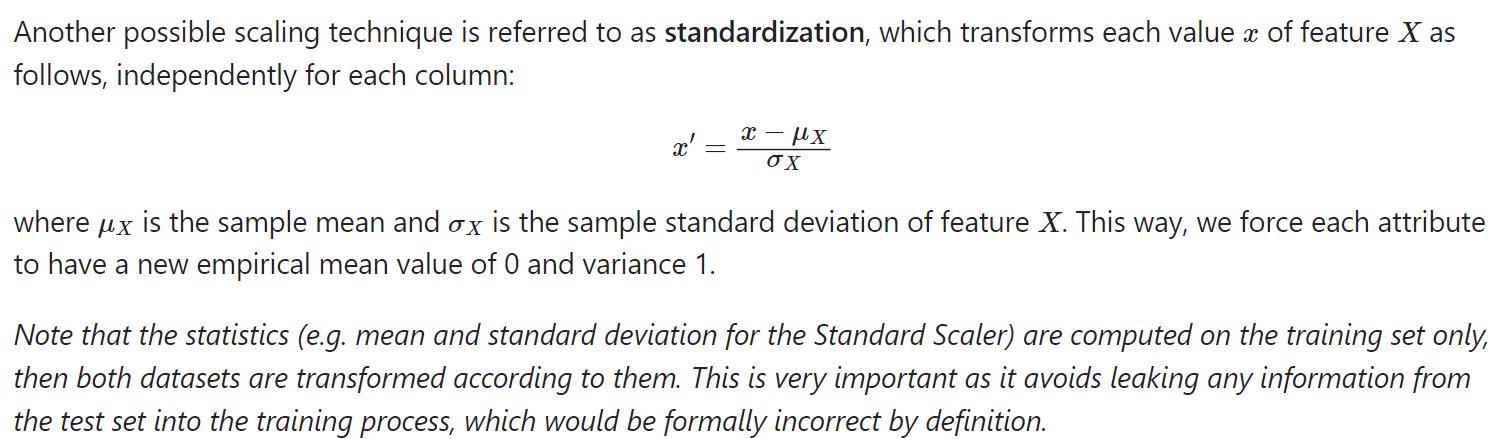### We need to scale the dataset appropriately

In [58]:
#performing standard scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)   #transforming the training dataset
x_test = scaler.transform(x_test)     #transforming the testing dataset

## Performing Logistic Regression

Now that we have processed our data and scaled it, we can move ahead to create and fit the logistic regression model.

In [59]:
# We need to create an object of the LogisticRegression() class and then call it to fit our model.
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

As there are 24 independent variables, we will have 24 corresonding coefficients (The assumption is that the reader should know the formula for logistic regression. This is just the implementation) and the bias term.

We can access this using the coef_ method. It is a good practise to view the trained parameters (here, coefficients and bias terms).

In [60]:
# Viewing the trained parameters
print(log_reg.coef_)
print(log_reg.intercept_)

[[-4.54591423e-02 -1.92352381e-02 -1.34917740e-02 -4.24344015e-02
   3.19326183e-02  2.32534953e-01  5.89381609e-02  3.12183032e-02
   1.50627460e-02  1.09050698e-02  2.07316004e-02 -4.30851080e-02
  -1.97462979e-02 -9.27702674e-03 -6.58746295e-03  1.72562900e-02
   9.42606696e-03 -4.81942166e-02 -5.64559458e-02 -2.57255353e-02
  -2.88464064e-02 -2.00216946e-02 -1.07791311e-02  6.72432436e+00]]
[-5.17521512]


## Visualizing the results

Now that we have a trained model, we can go ahead and predic the value of the dependent variable on an unseen dataset --> the testing dataset. As we have already scaled our testing dataset, we can directly fit the model and predict.

In [62]:
# Let us predict the values for the dependent variable in the testing dataset
y_pred = log_reg.predict(x_test)

# Nextfew steps are to visualise the actual value vs predicted value for our testing dataset
y_test_array = np.array(y_test)
predictions = {"Actual": y_test_array , "Predicted":y_pred}
df_compared = pd.DataFrame.from_dict(predictions)
df_compared

Actual  Predicted
0          0          0
1          0          0
2          0          0
3          1          1
4          1          1
...      ...        ...
5916       0          0
5917       0          0
5918       0          0
5919       0          0
5920       0          0

[5921 rows x 2 columns]

Now let us calculate and visualise the Confusion Matrix.
Also, let us first understand what the confusion matrix is.

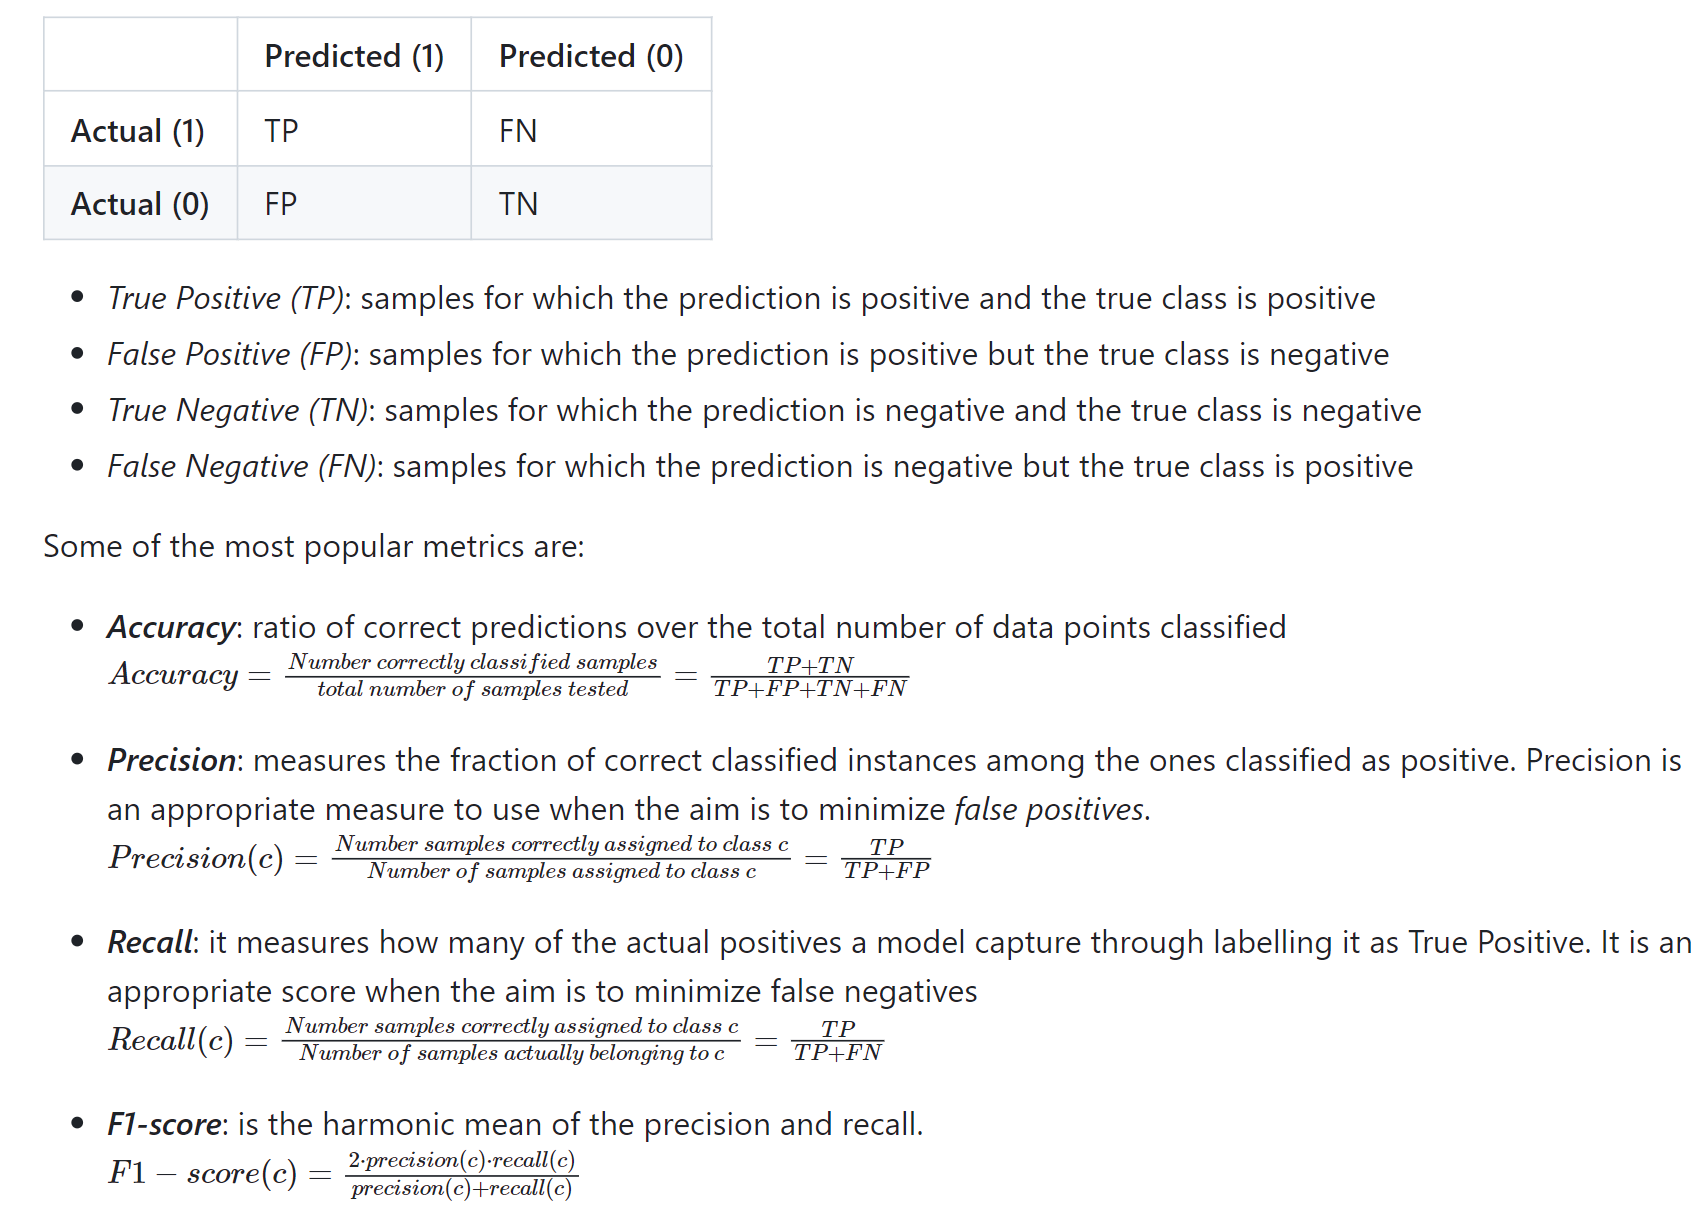Confusion matrix is as follows

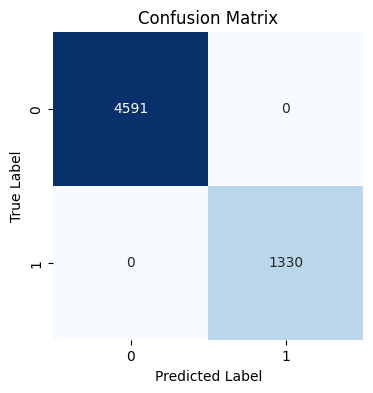

In [65]:
# Confusion Matrix is as follows
# Calculate confusion matrix
result = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Let us calculate the accuracy and precision

In [66]:
#From the formula given above,
accuracy = ( result[0,0] + result[1,1] )*100  / ( result[0,0] + result[0,1] + result[1,0] + result[1,1] )
precision = (result[0,0])*100 / ( result[0,0] + result[1,0] )
print(f"The code has accuracy of {accuracy:.2f}%.\nThe code has precision of {precision:.2f}%")

The code has accuracy of 100.00%.
The code has precision of 100.00%


## Analysing the results

We see that our logistic regression model has a 100% accuracy and a 100% precision. If your logistic regression model is reporting 100% accuracy and 100% precision, it indicates that the model is making perfect predictions on your dataset. While achieving such high performance may be possible in some scenarios, especially with well-separated classes and a high-quality dataset, it's also essential to consider potential reasons such as overfitting. Overfitting occurs when the model learns to memorize the training data instead of generalizing from it. This can happen if the model is too complex relative to the amount of training data, or if the features in the dataset contain noise or irrelevant information. Maybe becuase the data collected was very comprehensive and we took the testing data from the original dataset thus the training and testing dataset have very similar characteristics and hence the model learnt to predict very well.

In most real life applications, we never see a score this high. This is a rare case.

## Pros and Cons

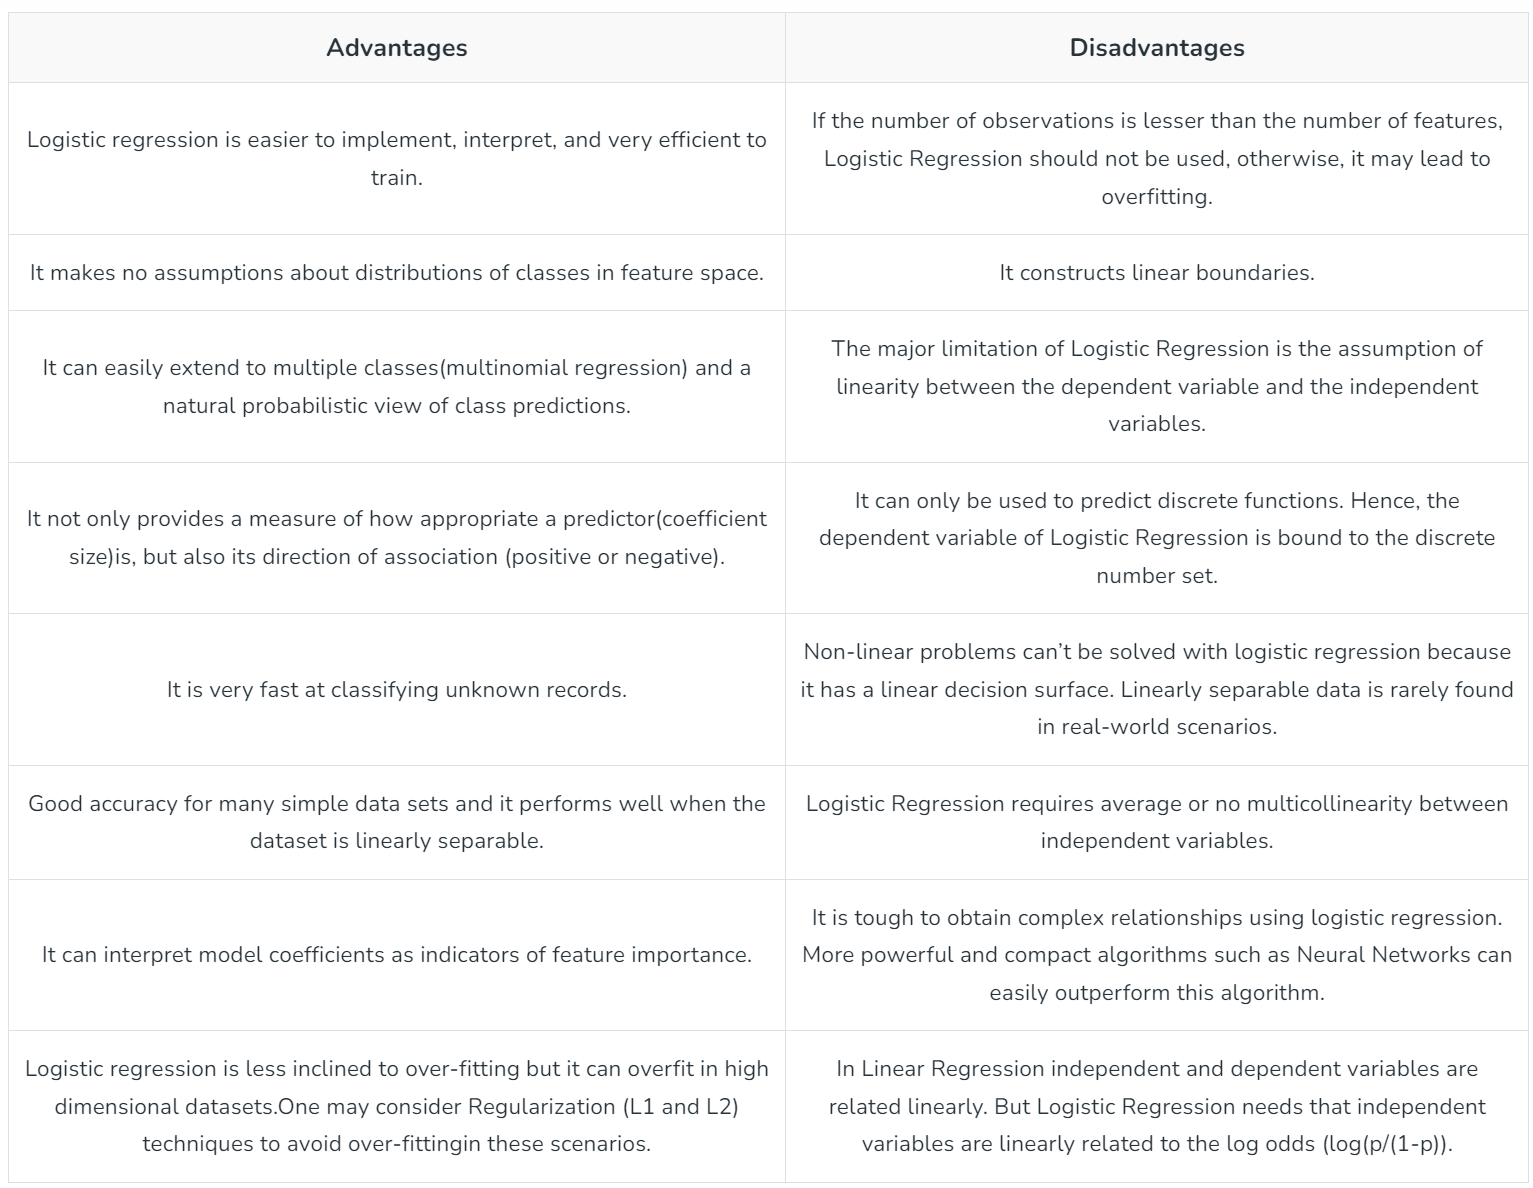

Source: https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/

# **Principal Component Analysis (PCA)**

## Introduction to PCA

Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set. Reducing the dimension of the dataset means reducing the number of independent variables. Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity and computational efficiency. Because smaller data sets are easier to explore and visualize, and thus make analyzing data points much easier and faster for machine learning algorithms without extraneous variables to process. So, to sum up, the idea of PCA is simple: reduce the number of variables of a data set, while preserving as much information as possible.

PCA captures the underlying structure of the data by identifying the directions (principal components) along which the data varies the most. Here's what PCA captures:

1. Variance: PCA captures the directions of maximum variance in the data. The first principal component (PC1) accounts for the most significant amount of variance, followed by the second principal component (PC2), and so on. Each subsequent principal component captures progressively less variance.
2. Linear Relationships: PCA captures linear relationships between variables in the dataset. It identifies the directions in which the variables are most strongly correlated or inversely correlated, allowing it to summarize the data using a smaller number of components.
3. Dimensionality Reduction: PCA captures the essential information in the data while reducing its dimensionality. By retaining the top principal components that explain most of the variance, PCA can represent the data in a lower-dimensional space without losing much information.
4. Feature Extraction: PCA can be used for feature extraction by transforming the original features into a new set of uncorrelated features (principal components). These principal components are linear combinations of the original features and can be used in subsequent analyses or modeling tasks.
5. Noise Reduction: PCA can help reduce the impact of noise or irrelevant information in the data by focusing on the directions of maximum variance and ignoring directions with low variance (which often correspond to noise).
6. Visualization: PCA can be used for data visualization by projecting high-dimensional data onto a lower-dimensional space (e.g., 2D or 3D) while preserving the essential structure of the data. This allows for easier exploration and interpretation of the data.

In summary, PCA captures the underlying structure of the data by identifying the directions of maximum variance and representing the data in a lower-dimensional space while retaining most of the information. It is a powerful technique for dimensionality reduction, feature extraction, noise reduction, and visualization in various data analysis and machine learning tasks.

**Keep in mind that PCA is not an ML model.** It is a part of pre-processing the dataset before feeding it into an ML model.

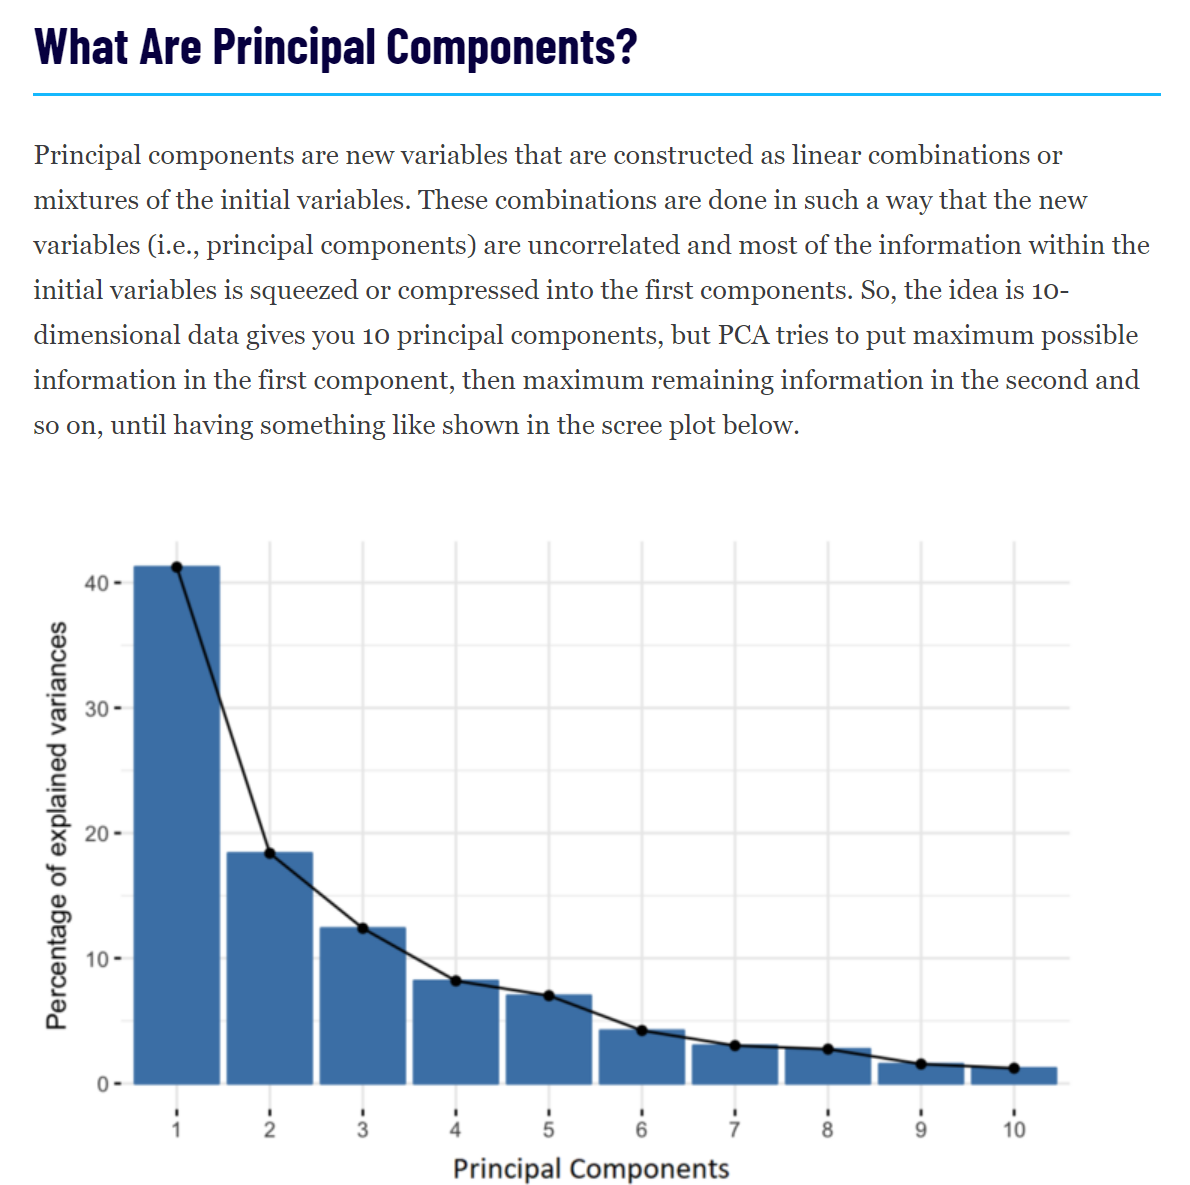

Source: https://builtin.com/data-science/step-step-explanation-principal-component-analysis

## Describing the Dataset

The dataset which I have used is has been downloaded from https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients.

It is a dataset of customers' default payments in Taiwan. There is so defined timeframe of the dataset except the information provided while elaborating on the variables below. Any and all info regarding the dataset is detailed below in the link provided below.

We will be using the same dataset as Logistic Regression. Our aim will be to reduce the dimension of the dependent variables from the initial 24.

The variables in the dataset are as follows.
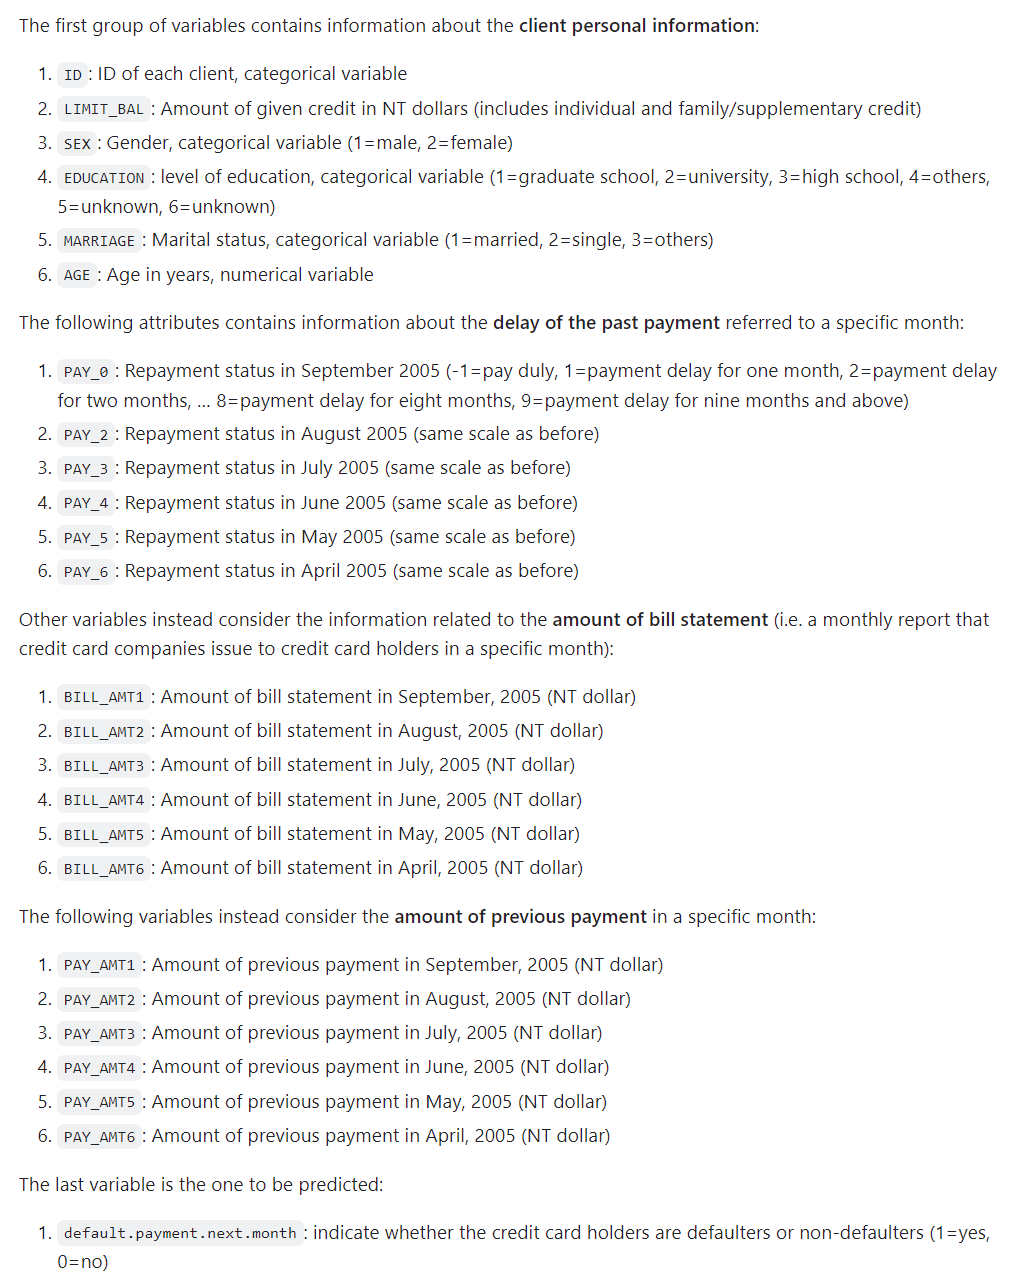![image.png]()


## Importing all the necessary libraries

In [67]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

## Importing Data, Processing it and visualising it

In [68]:
df = pd.read_excel('/content/DefaultCC.xlsx')   #reading the data
df = df.drop(df[df['marriage'] == 0].index)     #cleaning the dataset
df = df.drop(df[df['education'] == 0].index)    #cleaning the dataset
df = df.drop(df[df['education'] == 5].index)    #cleaning the dataset
df = df.drop(df[df['education'] == 6].index)    #cleaning the dataset
df

id  limit_bal  sex  education  marriage  age  pay_1  pay_2  pay_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       pay_4  ...  bill_4  bill_5  bill_6  pay_1.1  pay_2.1  pay_3.1  pay_4.1  \
0         -1  ...       0       0       0        0      689        0        0   
1          0  ...    3272    3455    3261        0     1000     1000     1000   
2          0  ...   14331   14948   15549     1518     1500     1000     1000   
3          0  ...   28314   28959   29547     2000     2019     1200     1100   
4          0  ...   20940   19146   19131     2000    36681    10000     9000   
...      ...  ...     ...     ...     ...      ...      ...      ...      ...   
29995      0  ...   88004   31237   15980     8500    20000     5003     3047   
29996     -1  ...    8979    5190       0     1837     3526     8998      129   
29997     -1  ...   20878   20582   19357        0        0    22000     4200   
29998      0  ...   52774   11855   48944    85900     3409     1178     1926   
29999      0  ...   36535   32428   15313     2078     1800     1430     1000   

       pay_5.1  pay_6.1  dflt  
0            0        0     1  
1            0     2000     1  
2         1000     5000     0  
3         1069     1000     0  
4          689      679     0  
...        ...      ...   ...  
29995     5000     1000     0  
29996        0        0     0  
29997     2000     3100     1  
29998    52964     1804     1  
29999     1000     1000     1  

[29601 rows x 25 columns]

In [69]:
# Let us drop the id column as it is irrelevant and after that let us plot a heatmap to view the correlation of each variable with the other
df_view = df.drop(['id'], axis=1).corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)
df_view.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})

We can see alot of areas with strong correlations. Especailly between all pay_1 to pay_6 and bill_1 to bill_6. Hence we do not necessarily need all of these and can make do with some linear combination of them.

Splitting data into independent and dependent variables is a fundamental step in many types of statistical analysis and machine learning tasks, including regression analysis, classification, and forecasting. The purpose of this splitting is to prepare the data for modeling by separating the features or predictors (independent variables) from the target or response variable (dependent variable).

1. Model Building: In most statistical and machine learning models, we aim to build a relationship between the input variables (independent variables) and the output variable (dependent variable). By separating them, we can clearly define what we are trying to predict or explain.
2. Prediction: In predictive modeling tasks, the independent variables are used to make predictions about the dependent variable. Splitting the data allows us to train the model on one subset (training set) and evaluate its performance on another subset (testing set or validation set).
3. Generalization: By evaluating the model's performance on a separate dataset (testing set or validation set), we can assess its ability to generalize to new, unseen data. This is essential for determining whether the model has learned meaningful patterns or is simply memorizing the training data.
4. Feature Engineering: Splitting the data facilitates feature engineering, where we can preprocess, transform, or create new features based on the independent variables without affecting the dependent variable.

In summary, splitting data into independent and dependent variables is a crucial step in preparing data for modeling, enabling effective model building, evaluation, and generalization. It helps ensure that the model learns meaningful patterns from the data and can make accurate predictions or inferences on new, unseen data.

In our data, we have 24 independent variables(x, x1 to x24) and 1 dependent variable(y). This dependent variable is the "Dflt" column which tells us if the customer has defaulted on a loan or not. Hence, this is how we will split our dataset.

In [70]:
#storing the independent variable and dependent variables in separate dataframes
# indepenedt varies = 24 columns and dependent variable will have 1 column
df_x = df.iloc[: , :-1]
df_x = df.drop(['id'],axis=1)
df_y = df['dflt']
df_x

limit_bal  sex  education  marriage  age  pay_1  pay_2  pay_3  pay_4  \
0          20000    2          2         1   24      2      2     -1     -1   
1         120000    2          2         2   26     -1      2      0      0   
2          90000    2          2         2   34      0      0      0      0   
3          50000    2          2         1   37      0      0      0      0   
4          50000    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995     220000    1          3         1   39      0      0      0      0   
29996     150000    1          3         2   43     -1     -1     -1     -1   
29997      30000    1          2         2   37      4      3      2     -1   
29998      80000    1          3         1   41      1     -1      0      0   
29999      50000    1          2         1   46      0      0      0      0   

       pay_5  ...  bill_4  bill_5  bill_6  pay_1.1  pay_2.1  pay_3.1  pay_4.1  \
0         -2  ...       0       0       0        0      689        0        0   
1          0  ...    3272    3455    3261        0     1000     1000     1000   
2          0  ...   14331   14948   15549     1518     1500     1000     1000   
3          0  ...   28314   28959   29547     2000     2019     1200     1100   
4          0  ...   20940   19146   19131     2000    36681    10000     9000   
...      ...  ...     ...     ...     ...      ...      ...      ...      ...   
29995      0  ...   88004   31237   15980     8500    20000     5003     3047   
29996      0  ...    8979    5190       0     1837     3526     8998      129   
29997      0  ...   20878   20582   19357        0        0    22000     4200   
29998      0  ...   52774   11855   48944    85900     3409     1178     1926   
29999      0  ...   36535   32428   15313     2078     1800     1430     1000   

       pay_5.1  pay_6.1  dflt  
0            0        0     1  
1            0     2000     1  
2         1000     5000     0  
3         1069     1000     0  
4          689      679     0  
...        ...      ...   ...  
29995     5000     1000     0  
29996        0        0     0  
29997     2000     3100     1  
29998    52964     1804     1  
29999     1000     1000     1  

[29601 rows x 24 columns]

## Implementing PCA and Visualising the Data

When performing PCA, the choice of the explained variance threshold, often denoted as 𝛼, such as 0.95, is based on the cumulative explained variance. The cumulative explained variance represents the proportion of total variance in the data (independent variables) captured by the principal components. Here's why 0.95 is often chosen:

1. Retaining Sufficient Information: By selecting a cumulative explained variance threshold of 0.95, we aim to retain at least 95% of the total variance in the original data. This ensures that the reduced-dimensional representation obtained through PCA preserves a large majority of the information present in the original dataset.
2. Dimensionality Reduction: PCA is commonly used for dimensionality reduction, where the goal is to reduce the number of features or variables while retaining as much information as possible. Choosing a threshold like 0.95 ensures that the reduced-dimensional representation captures a high proportion of the variability in the original data.
3. Trade-off Between Dimensionality and Information Loss: Selecting a threshold of 0.95 represents a trade-off between reducing dimensionality (i.e., reducing the number of principal components) and minimizing information loss. It strikes a balance between reducing computational complexity and retaining sufficient information for subsequent analyses or modeling tasks.
4. Common Practice: Choosing a threshold of 0.95 is a common practice in data analysis and machine learning. It provides a standardized criterion for determining the number of principal components to retain, making results more interpretable and comparable across different analyses.
5. Rule of Thumb: While the choice of threshold may vary depending on the specific requirements of the analysis or the characteristics of the data, 0.95 is often considered a reasonable default threshold in many applications. It provides a practical guideline for dimensionality reduction without sacrificing too much information.

In summary, selecting a threshold of 0.95 for PCA ensures that the reduced-dimensional representation retains a high proportion of the total variance in the original data, striking a balance between dimensionality reduction and information preservation.

In [71]:
# Setting explained variance threshold to 0.95
pca = PCA(0.95)
pca.fit(df_x)

PCA(n_components=0.95)

Visualising the Dataset in terms of it's new coordinates

In [73]:
#transforming data to pca coordinates
pca_coordinates = pca.transform(df_x)
pca_coordinates.shape

(29601, 4)

We see that around 95% of all information was captured in just 4 components! This is a huge reduction in the dimension from 24. Although we compromise on 5% of the information, we save up the memory and compute associated with 20 components.

In [74]:
#We notice from above that 4 features are enough to capture 95% of the information
label = ['PC' + str(x) for x in range(1,len(pca_coordinates[0])+1) ]
pca_df = pd.DataFrame(pca_coordinates, columns=label)
pca_df

PC1           PC2            PC3           PC4
0     -166445.588229 -75187.239036    -418.721130   -116.598099
1     -113867.561211   9939.752352    2700.181180  -1584.654056
2      -98237.068483 -33370.855398   -2788.693839  -4988.239854
3      -71276.580530 -95220.462942  -10045.064628   4613.077575
4     -114743.107604 -68576.290424   25104.052320  34006.245847
...              ...           ...            ...           ...
29596  199888.640435 -56406.866313 -140884.813190  78756.164517
29597  -97265.675480  35189.450762    4735.917990   1667.356936
29598 -140134.595138 -77607.533810   26171.010819  -7519.987346
29599  -41375.591676 -75013.241253   18434.539380  44453.678609
29600  -70918.406605 -95501.962283  -14091.104178   8894.563057

[29601 rows x 4 columns]

Just as an added exercise, let us plot a graph to visualise the amount of information captured vs the number of principal components.

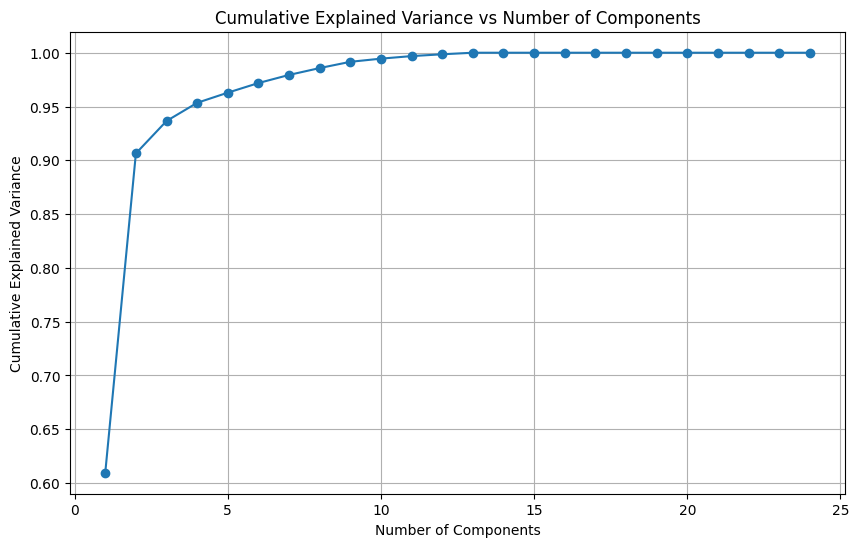

In [76]:
# Initialize PCA with desired number of components
pca = PCA()

# Fit PCA to the data
pca.fit(df_x)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance versus number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

## Conclusion

From the last graph, we see that 1 principal component (it is a linear combination of some subset of the original independent variables) is enough to capture almost 90% of the variance in the data. 4 principal components are enough to capture around 95% of the data and around 13 are enough to capture alost 100% of the information in the data. So basically the last 11 components are almost inconsequential in capturing information.

Let us also state the pros and cons of PCA to be clear about them.

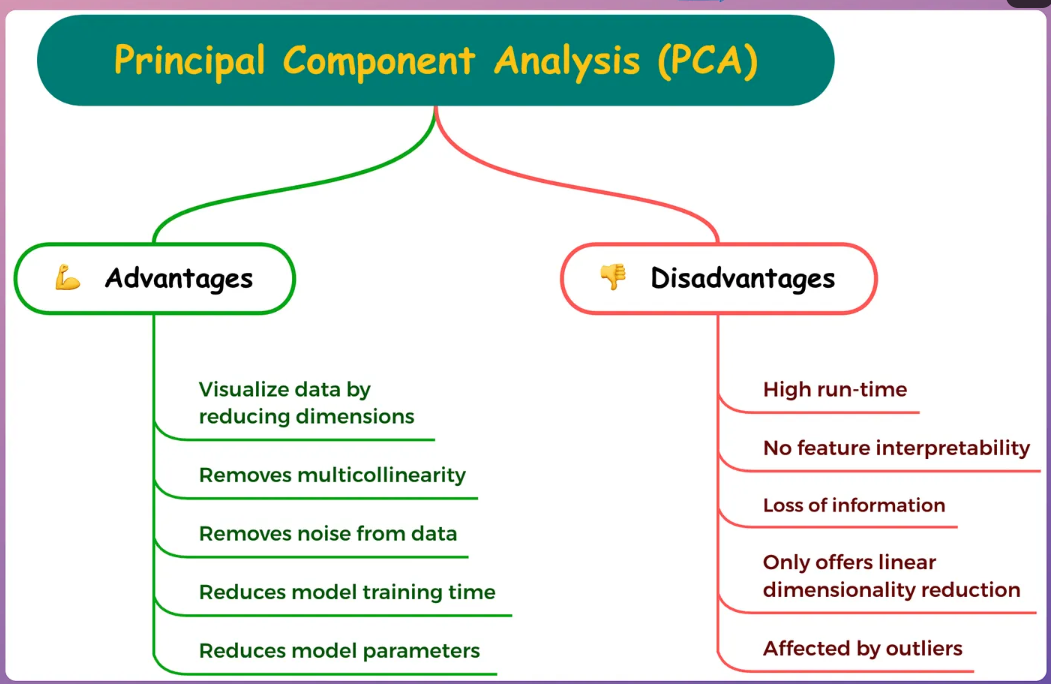

Source: https://www.blog.dailydoseofds.com/p/the-advantages-and-disadvantages

# **BONUS OPPORTUNITY - Combining Logistic Regression and PCA**

## Introduction

Using logistic regression and PCA (Principal Component Analysis) together can offer several advantages in various machine learning and data analysis tasks. Here's an introduction to why you might use them together:

1. Dimensionality Reduction: PCA can be used to reduce the dimensionality of high-dimensional datasets by transforming the original features into a lower-dimensional space while preserving most of the variability in the data. This can be beneficial for logistic regression, especially when dealing with datasets with a large number of features, as it helps reduce the risk of overfitting and improves computational efficiency.
2. Improved Model Performance: By reducing the dimensionality of the feature space, PCA can help improve the performance of logistic regression models. It can remove redundant or irrelevant features, focus on the most informative features, and mitigate the effects of multicollinearity, leading to more stable and interpretable logistic regression models.
3. Addressing Multicollinearity: In datasets with highly correlated features (multicollinearity), logistic regression models may suffer from instability and inflated coefficient estimates. PCA can mitigate multicollinearity by transforming the original features into orthogonal (uncorrelated) principal components, which can improve the robustness of logistic regression models.
4. Visualization and Interpretability: PCA can be used for data visualization by projecting high-dimensional data onto a lower-dimensional space. This can help visualize the underlying structure of the data and identify patterns or clusters. Combining PCA with logistic regression allows for the interpretation of the transformed principal components in terms of their impact on the logistic regression outcome.
5. Feature Engineering and Selection: PCA can be viewed as a form of feature engineering that automatically generates new features (principal components) from the original data. Logistic regression models built on these principal components can provide insights into which features are most important for predicting the outcome variable, facilitating feature selection and model interpretability.

In summary, using logistic regression and PCA together offers a powerful approach for analyzing high-dimensional data, improving model performance, addressing multicollinearity, visualizing data, and interpreting model results. By leveraging the strengths of both techniques, practitioners can develop more efficient, interpretable, and robust predictive models for various machine learning and data analysis tasks.

## Describing the dataset

The dataset which I have used is has been downloaded from https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients.

It is a dataset of customers' default payments in Taiwan. There is so defined timeframe of the dataset except the information provided while elaborating on the variables below. Any and all info regarding the dataset is detailed below in the link provided below.

The variables in the dataset are as follows.
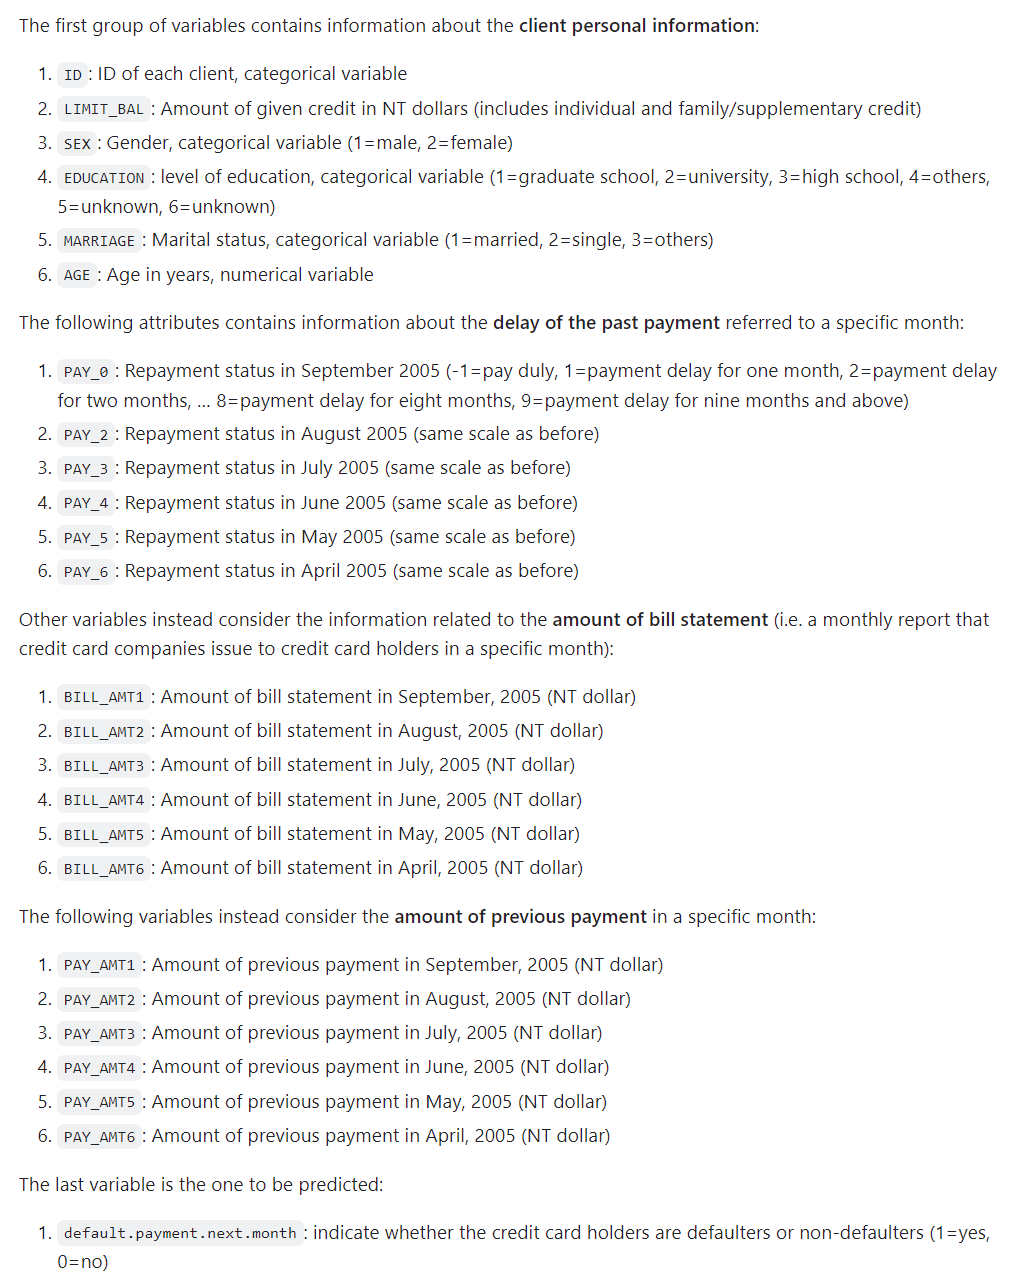![image.png]()


## Importing all the necessary libraries

In [79]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

## Importing Data, Processing it and visualising it

In [80]:
df = pd.read_excel('/content/DefaultCC.xlsx')   #reading the data
df = df.drop(df[df['marriage'] == 0].index)     #cleaning the dataset
df = df.drop(df[df['education'] == 0].index)    #cleaning the dataset
df = df.drop(df[df['education'] == 5].index)    #cleaning the dataset
df = df.drop(df[df['education'] == 6].index)    #cleaning the dataset
df

id  limit_bal  sex  education  marriage  age  pay_1  pay_2  pay_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       pay_4  ...  bill_4  bill_5  bill_6  pay_1.1  pay_2.1  pay_3.1  pay_4.1  \
0         -1  ...       0       0       0        0      689        0        0   
1          0  ...    3272    3455    3261        0     1000     1000     1000   
2          0  ...   14331   14948   15549     1518     1500     1000     1000   
3          0  ...   28314   28959   29547     2000     2019     1200     1100   
4          0  ...   20940   19146   19131     2000    36681    10000     9000   
...      ...  ...     ...     ...     ...      ...      ...      ...      ...   
29995      0  ...   88004   31237   15980     8500    20000     5003     3047   
29996     -1  ...    8979    5190       0     1837     3526     8998      129   
29997     -1  ...   20878   20582   19357        0        0    22000     4200   
29998      0  ...   52774   11855   48944    85900     3409     1178     1926   
29999      0  ...   36535   32428   15313     2078     1800     1430     1000   

       pay_5.1  pay_6.1  dflt  
0            0        0     1  
1            0     2000     1  
2         1000     5000     0  
3         1069     1000     0  
4          689      679     0  
...        ...      ...   ...  
29995     5000     1000     0  
29996        0        0     0  
29997     2000     3100     1  
29998    52964     1804     1  
29999     1000     1000     1  

[29601 rows x 25 columns]

In [81]:
#let us drop the id column as it is irrelevant and after that let us plot a heatmap to view the correlation of each variable with the other
df_view = df.drop(['id'], axis=1).corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)
df_view.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})

We can see alot of areas with strong correlations. Especailly between all pay_1 to pay_6 and bill_1 to bill_6. Hence we do not necessarily need all of these and can make do with some linear combination of them.

Splitting data into independent and dependent variables is a fundamental step in many types of statistical analysis and machine learning tasks, including regression analysis, classification, and forecasting. The purpose of this splitting is to prepare the data for modeling by separating the features or predictors (independent variables) from the target or response variable (dependent variable).

1. Model Building: In most statistical and machine learning models, we aim to build a relationship between the input variables (independent variables) and the output variable (dependent variable). By separating them, we can clearly define what we are trying to predict or explain.
2. Prediction: In predictive modeling tasks, the independent variables are used to make predictions about the dependent variable. Splitting the data allows us to train the model on one subset (training set) and evaluate its performance on another subset (testing set or validation set).
3. Generalization: By evaluating the model's performance on a separate dataset (testing set or validation set), we can assess its ability to generalize to new, unseen data. This is essential for determining whether the model has learned meaningful patterns or is simply memorizing the training data.
4. Feature Engineering: Splitting the data facilitates feature engineering, where we can preprocess, transform, or create new features based on the independent variables without affecting the dependent variable.

In summary, splitting data into independent and dependent variables is a crucial step in preparing data for modeling, enabling effective model building, evaluation, and generalization. It helps ensure that the model learns meaningful patterns from the data and can make accurate predictions or inferences on new, unseen data.

In our data, we have 24 independent variables(x, x1 to x24) and 1 dependent variable(y). This dependent variable is the "Dflt" column which tells us if the customer has defaulted on a loan or not. Hence, this is how we will split our dataset.

In [82]:
#storing the independent variable and dependent variables in separate dataframes
# indepenedt varies = 24 columns and dependent variable will have 1 column
df_x = df.iloc[: , :-1]
df_x = df.drop(['id'],axis=1)
df_y = df['dflt']
df_x

limit_bal  sex  education  marriage  age  pay_1  pay_2  pay_3  pay_4  \
0          20000    2          2         1   24      2      2     -1     -1   
1         120000    2          2         2   26     -1      2      0      0   
2          90000    2          2         2   34      0      0      0      0   
3          50000    2          2         1   37      0      0      0      0   
4          50000    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995     220000    1          3         1   39      0      0      0      0   
29996     150000    1          3         2   43     -1     -1     -1     -1   
29997      30000    1          2         2   37      4      3      2     -1   
29998      80000    1          3         1   41      1     -1      0      0   
29999      50000    1          2         1   46      0      0      0      0   

       pay_5  ...  bill_4  bill_5  bill_6  pay_1.1  pay_2.1  pay_3.1  pay_4.1  \
0         -2  ...       0       0       0        0      689        0        0   
1          0  ...    3272    3455    3261        0     1000     1000     1000   
2          0  ...   14331   14948   15549     1518     1500     1000     1000   
3          0  ...   28314   28959   29547     2000     2019     1200     1100   
4          0  ...   20940   19146   19131     2000    36681    10000     9000   
...      ...  ...     ...     ...     ...      ...      ...      ...      ...   
29995      0  ...   88004   31237   15980     8500    20000     5003     3047   
29996      0  ...    8979    5190       0     1837     3526     8998      129   
29997      0  ...   20878   20582   19357        0        0    22000     4200   
29998      0  ...   52774   11855   48944    85900     3409     1178     1926   
29999      0  ...   36535   32428   15313     2078     1800     1430     1000   

       pay_5.1  pay_6.1  dflt  
0            0        0     1  
1            0     2000     1  
2         1000     5000     0  
3         1069     1000     0  
4          689      679     0  
...        ...      ...   ...  
29995     5000     1000     0  
29996        0        0     0  
29997     2000     3100     1  
29998    52964     1804     1  
29999     1000     1000     1  

[29601 rows x 24 columns]

While training a Machine Learning model, we split our 'Supervised' Dataset into a Training Dataset and a Testing Dataset. We use the training dataset to 'train' our model and the testing dataset to verify how accurate our trained model is at predicting on unknown data (The training data is unknown to the model as we have not used it to train the paramaters).

  1. X_train: This will be the training set of features (size = 80% of training set).
  2. X_test: This will be the testing set of features (size = 20% of testing set).
  3. y_train: This will be the corresponding training set of target values (size = 80% of training set).
  4. y_test: This will be the corresponding testing set of target values (size = 20% of testing set).

By default, 80% of the data will be used for training (X_train and y_train), and 20% will be used for testing (X_test and y_test).. It is a standard practise to use an 80-20 split. The motivation behind this is loosely the Pareto principle.The Pareto principle is not a mathematically guaranteed property, but many observed phenomena follow the Pareto principle. As it is seen ubiquitous in nature, we try to emulate the same conjecture with our model. After all, we are trying to emulate 'intelligence'.

In [ ]:
#divide both variable into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state=42)

**Scaling the Data:** Data scaling is the process of transforming the values of the features of a dataset till they are within a specific range, e.g. 0 to 1 or -1 to 1. This is to ensure that no single feature 'dominates' the distance calculations in an algorithm, and can help to improve the performance of the algorithm.

Scaling your data in machine learning is important because many algorithms use the L-2 norm between two data points in their computations, which is sensitive to the scale of the variables. If one variable is on a much larger scale than another, that variable will dominate the distance calculation, and the algorithm will be affected by that variable more than the other irrespective of the importance of that variable in being a predictor. Scaling the data can help to balance the impact of all variables on the distance calculation and can help to improve the performance of the algorithm.

Source: https://medium.com/codex/why-scaling-your-data-is-important-1aff95ca97a2

The following code uses the StandardScaler object from scikit-learn to standardize the features in both the training and testing sets. Standardization (or Z-score normalization) is a common preprocessing step in machine learning that helps to scale features to have zero mean and unit variance. As mentioned above, Standardizing features is important because it helps to ensure that all features contribute equally to the learning process, and it can improve the performance of certain machine learning algorithms. Keep in mind, we need to scale features on both - the training AND testing sets.

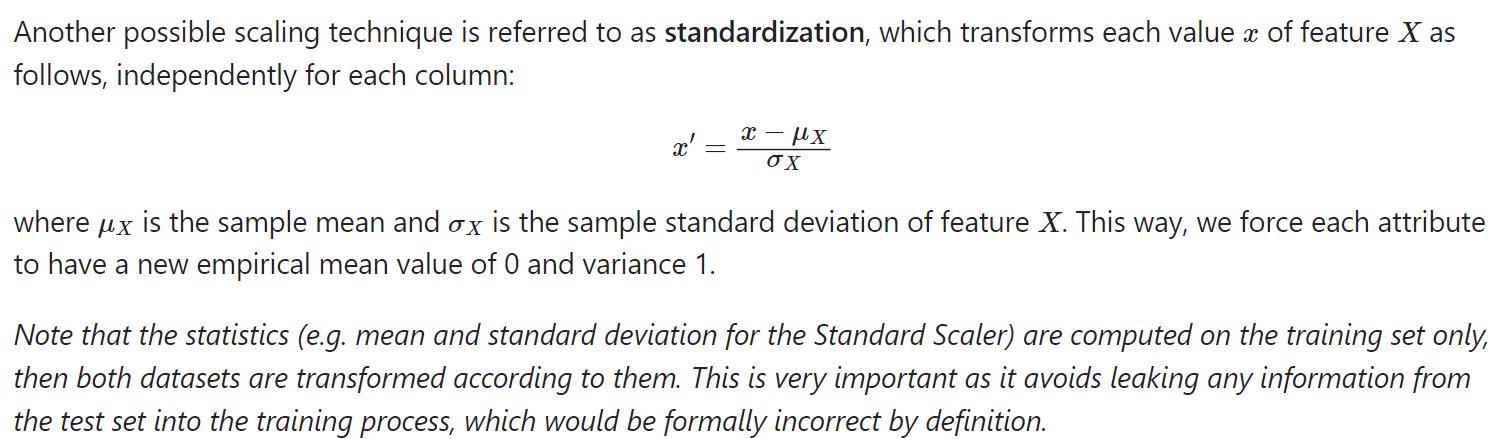### We need to scale the dataset appropriately

In [83]:
#performing standard scaling
scaler = StandardScaler()
scaler.fit(x_train)
df_train = scaler.transform(x_train)   #transforming the training dataset
df_test = scaler.transform(x_test)     #transforming the testing dataset

## Implementing PCA and Visualising the Data

Running PCA to reduce our dimension from 24 to 8. This can be done by orienting our data along the eigenvectors corresponding to the top 8 eigenvalues. As seen in the PCA section, this transformation captures 98% of information. Hence by reducing 67% of the dataset, we still only reduce 2% of the information.

In [94]:
# Setting dimension = 8
# Fitting will be done on training dataset only as we want to extrapolate testing information from this
pca = PCA(n_components=8)
pca.fit(df_train)

PCA(n_components=8)

Visualising the Dataset in terms of it's new coordinates

In [95]:
#transforming data to pca coordinates
pca_coordinates = pca.transform(df_train)
pca_coordinates.shape

(23680, 8)

In [96]:
#Visualising the training dataset in terms of the PCA coordinates
label = ['PC' + str(x) for x in range(1,len(pca_coordinates[0])+1) ]
x_train_pca = pd.DataFrame(pca_coordinates, columns=label)
x_train_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      3.732792  1.631369 -0.949883 -0.139534  1.009278 -0.332044 -0.296333   
1      0.002927 -0.582380 -0.747017  0.240139  1.110116 -0.123558 -0.434777   
2     -3.297740  1.727568 -0.254653 -1.030464 -1.419095  0.343849  1.969944   
3      0.713319 -0.184277  0.773918 -1.453784 -1.005103  0.920492 -0.387200   
4     -1.160294  0.121135  0.013664  0.716137  1.084264 -0.233441 -0.313948   
...         ...       ...       ...       ...       ...       ...       ...   
23675 -2.948875  0.807094 -0.209542 -1.239065 -0.019722 -1.124690  2.695900   
23676 -2.846260  3.229785 -0.937189  0.812855  0.672363 -0.382123 -0.136465   
23677  1.303639  0.236905 -1.021252  0.259691  0.993805 -0.235765 -0.456057   
23678  4.373143 -1.738188 -1.056693  0.330236  0.616763 -1.369738  1.607751   
23679  0.677598 -4.324352  0.742695  0.076953 -0.635753  0.630758  1.524884   

            PC8  
0     -0.040085  
1      0.092308  
2     -0.079890  
3      0.188683  
4     -0.582422  
...         ...  
23675 -0.145411  
23676  0.354174  
23677  0.082526  
23678 -0.903541  
23679 -0.544770  

[23680 rows x 8 columns]

## Running Logistic Regression on this reduced dataset

In [97]:
# Creating an instance of the LogisticRegression() class
log_reg = LogisticRegression()
log_reg.fit(x_train_pca, y_train)

LogisticRegression()

As there are 4 independent variables (4 principal components), we will have 4 corresonding coefficients (The assumption is that the reader should know the formula for logistic regression. This is just the implementation) and the bias term.

We can access this using the coef_ method. It is a good practise to view the trained parameters (here, coefficients and bias terms).

In [98]:
#visualising the weights and biases of our regression
print(log_reg.coef_)
print(log_reg.intercept_)

[[ 0.23804797 -1.51351091 -0.59400756  0.58722687 -2.7117609  -3.90108279
   4.7082903   0.72057766]]
[-5.50855271]


We will also need to convert the testing dataset to the reduced coordinates as our logistic regression model is fit in terms of principal components and not the initial variables.

In [99]:
pca_test = pca.transform(df_test)
label = ['PC' + str(x) for x in range(1,len(pca_coordinates[0])+1) ]
x_test_pca = pd.DataFrame(pca_test, columns=label)
x_test_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.312183 -1.200552 -0.139581  0.163711  1.145971 -0.229891 -0.511440   
1     1.210322 -1.561191  0.989463  1.304880  0.081219  1.434536 -0.987211   
2    -0.517643 -0.493944  1.141999 -1.280635  0.462335 -0.412850 -1.229793   
3    -2.869809  1.433914 -0.752635 -0.417273 -1.095966 -1.902432  1.703611   
4    -0.214584 -1.060028 -0.781983  0.914712  0.241911 -1.273579  1.082754   
...        ...       ...       ...       ...       ...       ...       ...   
5916 -0.861366 -2.070144  0.304236  0.108740  0.241186  2.091262 -0.025431   
5917  1.435800  0.891712  0.829712 -1.528574  0.117295 -0.930711 -0.994574   
5918  4.716660  4.018038  2.846965  0.029819 -1.245017 -3.349805 -0.930226   
5919 -2.218105  0.565125  0.803633 -0.994882  1.157876  0.311745  0.328659   
5920 -0.054501  0.522897 -0.152138  0.369325 -0.086513 -1.464731 -1.653044   

            PC8  
0      0.098497  
1      0.433222  
2      0.394164  
3      0.570428  
4      0.080581  
...         ...  
5916  -0.550884  
5917   0.434689  
5918 -12.178011  
5919  -0.390621  
5920   1.054778  

[5921 rows x 8 columns]

Predicting values of the depenedent variable (Dflt) of the testing dataset (y_test).

In [100]:
#let us predict the dependent variable
y_pred = log_reg.predict(x_test_pca)

#nextfew steps are to visualise the actual value vs predicted value for our testing dataset
y_test_array = np.array(y_test)
predictions = {"Actual": y_test_array , "Predicted":y_pred}
df_compared = pd.DataFrame.from_dict(predictions)
df_compared

Actual  Predicted
0          0          0
1          0          0
2          0          0
3          1          1
4          1          1
...      ...        ...
5916       0          0
5917       0          0
5918       0          0
5919       0          0
5920       0          0

[5921 rows x 2 columns]

## Visualising the result

Let us calculate the Confusion Matrix. Let us also understand what the confusion matrix is.

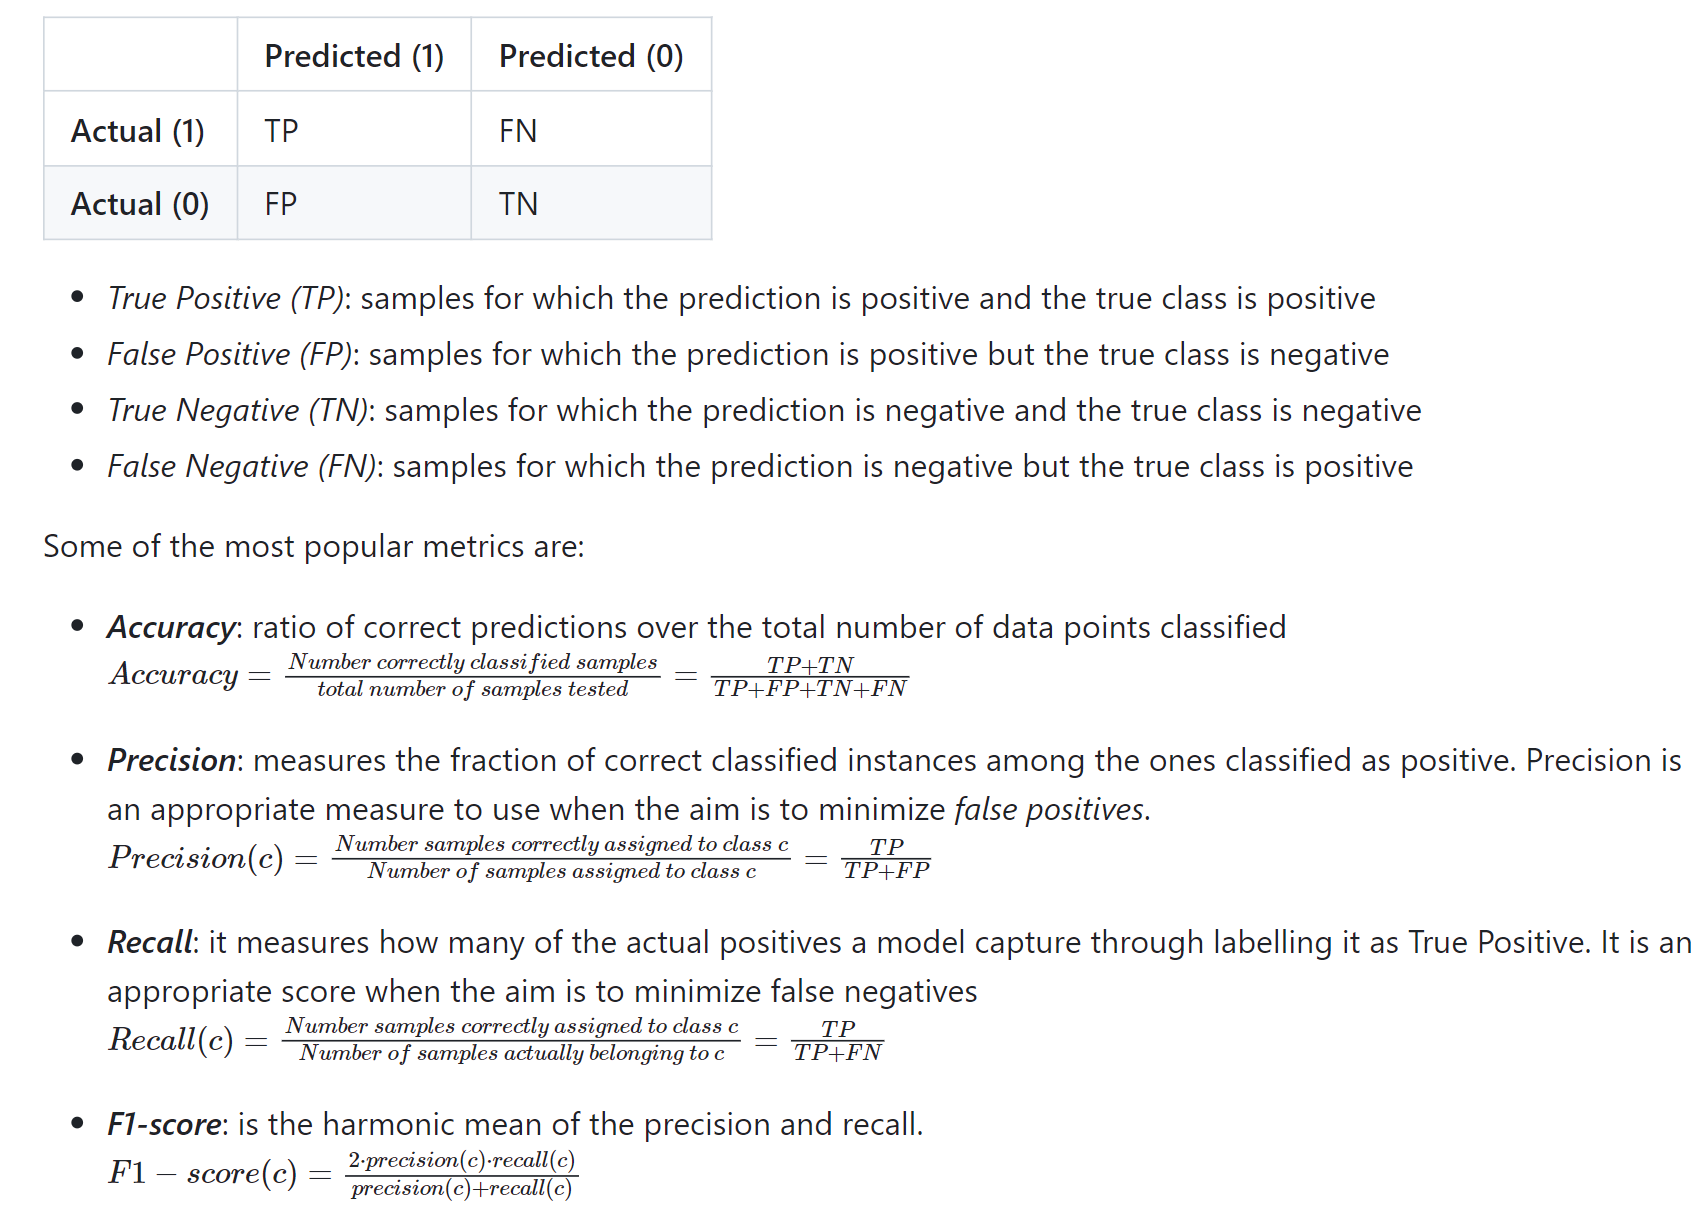Confusion matrix is as follows

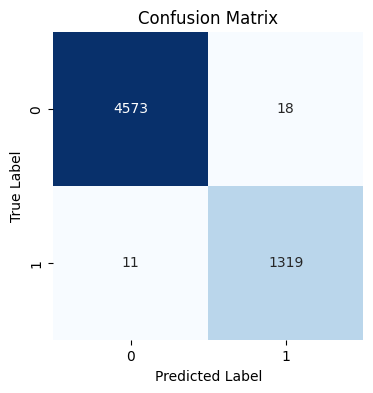

In [103]:
# Confusion Matrix is as follows
# Calculate confusion matrix
result = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Calculating Accuracy and Prediction

In [104]:
#From the formula given above,
accuracy = ( result[0,0] + result[1,1] )*100  / ( result[0,0] + result[0,1] + result[1,0] + result[1,1] )
precision = (result[0,0])*100 / ( result[0,0] + result[1,0] )
print(f"The code has accuracy of {accuracy:.2f}%.\nThe code has precision of {precision:.2f}%")

The code has accuracy of 99.51%.
The code has precision of 99.76%


## Analysing the Results

We see that our code has accuracy of 99.51% and a precision of 99.76%.
As compared to the initial 100% accuracy we got from Logistic Regression without PCA, this is hardly any difference.

Wr reduced the dimension of the dataset by two-thirds and still preserved such a high accuracy. This is the beauty of PCA. Reducing complexity and compute at the expense of a little bit of accuracy.

## Conclusion

While in our particular use case, the combination of Logistic Regression and PCA gave a slightly lesser accuracy, this is not always the case. This may be due to the nature of the dataset - it might have been a very easily learnable dataset or not too complex and hence logistic regression was able to easily fit to it hence giving a 100% accuracy.

But by doing PCA and then fitting the ML model, We compromise on a little bit of accuracy but save up a lot of computational costs in the process.